# Camera Setup

In [ ]:
import cv2
import cv2.aruco as aruco
import os
import numpy as np
import subprocess

# Camera 0 refers to top camera, Camera 1 refers to bottom camera
# Ensure camera port ids are correct
port_ids = [2, 0]
cam0_device = f"/dev/cam0"
cam1_device = f"/dev/cam1"

# Ensure proper camera configurations
cam0_focus_value = 35
cam1_focus_value = 75
config_commands = {cam0_device: [
                    f"v4l2-ctl -d {cam0_device} -c focus_automatic_continuous=0",
                    f"v4l2-ctl -d {cam0_device} -c auto_exposure=3",
                    f"v4l2-ctl -d {cam0_device} -c focus_absolute={cam0_focus_value}",
                    # f"v4l2-ctl -d {device} -c exposure_time_absolute=333",
                    # f"v4l2-ctl -d {device} -c gain=0",
                    # f"v4l2-ctl -d {device} -c white_balance_automatic=0",
                    # f"v4l2-ctl -d {device} -c white_balance_temperature=4675",
                    # f"v4l2-ctl -d {device} -c brightness=128",
                    # f"v4l2-ctl -d {device} -c contrast=128",
                    # f"v4l2-ctl -d {device} -c saturation=128",
                    ],
                cam1_device: [
                    f"v4l2-ctl -d {cam1_device} -c focus_automatic_continuous=0",
                    f"v4l2-ctl -d {cam1_device} -c auto_exposure=3",
                    f"v4l2-ctl -d {cam1_device} -c focus_absolute={cam1_focus_value}",
                    # f"v4l2-ctl -d {device} -c exposure_time_absolute=333",
                    # f"v4l2-ctl -d {device} -c gain=0",
                    # f"v4l2-ctl -d {device} -c white_balance_automatic=0",
                    # f"v4l2-ctl -d {device} -c white_balance_temperature=4675",
                    # f"v4l2-ctl -d {device} -c brightness=128",
                    # f"v4l2-ctl -d {device} -c contrast=128",
                    # f"v4l2-ctl -d {device} -c saturation=128",
                    ]
                }

def configure_camera(devices, config_commands):
    for device in devices:

        print(f"Configuring camera on {device}...")

        for command in config_commands[device]:
            subprocess.run(command, shell=True, check=True)

        print("Camera configuration complete!")

# Grab some test images of catheter tip

In [ ]:
# Collect images of calibration board in both cameras frames for stereo extrinsic calibration
import cv2
import datetime
import os

output_dir = f"../tip_pose_images/test_highres"
os.makedirs(output_dir, exist_ok=True)

# Make sure cameras are configures
# configure_camera([cam0_device, cam1_device], config_commands) # Uncomment to use default configs
cap0 = cv2.VideoCapture(cam0_device, cv2.CAP_V4L2)
cap1 = cv2.VideoCapture(cam1_device, cv2.CAP_V4L2)
cap0.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cap0.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
cap1.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cap1.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
frame_count = 0
while True:
    # Read frames from both cameras
    ret0, frame0 = cap0.read()
    ret1, frame1 = cap1.read()

    if not ret0 or not ret1:
        print("Error: One or both frames could not be read.")
        break

    # Display both camera feeds with timestamps
    # timestamp = datetime.now().strftime("%H:%M:%S.%f")
    # cv2.putText(frame1, f"Cam1 - {timestamp}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # cv2.putText(frame2, f"Cam2 - {timestamp}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # Resize frames to 640x480
    frame0 = cv2.resize(frame0, (640, 480))
    frame1 = cv2.resize(frame1, (640, 480))
    # Combine and display both frames
    combined = cv2.hconcat([frame0, frame1])
    cv2.imshow("Camera 0 (top) + Camera 1 (side)", combined)

    key = cv2.waitKey(1) & 0xFF

    if key == 27:  # ESC key to exit
        break
    elif key == ord(' '):  # Space key to capture images
        img0_path = f"{output_dir}/cam0_{frame_count}.png"
        img1_path = f"{output_dir}/cam1_{frame_count}.png"
        cv2.imwrite(img0_path, frame0)
        cv2.imwrite(img1_path, frame1)
        print(f"Captured images:\n - {img0_path}\n - {img1_path}")
        frame_count += 1

# Release both cameras and close windows
cap0.release()
cap1.release()
cv2.destroyAllWindows()

# Manual Crop Selection

In [ ]:
import cv2

# Find a good bounding box for the scene in both camera frames
def select_bounding_box(image):
    box_coords = []

    def on_mouse(event, x, y, flags, param):
        nonlocal box_coords
        if event == cv2.EVENT_LBUTTONDOWN:
            box_coords = [(x, y)]
        elif event == cv2.EVENT_LBUTTONUP:
            box_coords.append((x, y))
            cv2.rectangle(image_disp, box_coords[0], box_coords[1], (0, 255, 0), 2)
            cv2.imshow("Select Bounding Box", image_disp)

    image_disp = image.copy()
    cv2.imshow("Select Bounding Box", image_disp)
    cv2.setMouseCallback("Select Bounding Box", on_mouse)

    while True:
        key = cv2.waitKey(0) & 0xFF
        if key == 27:  # ESC key to finish
            break

    cv2.destroyAllWindows()

    if len(box_coords) == 2:
        x1, y1 = box_coords[0]
        x2, y2 = box_coords[1]
        return (x1, y1, x2, y2)
    else:
        raise ValueError("Bounding box not selected properly.")

base_folder = r"C:\Users\jlim\Documents\GitHub\Catheter-Perception\camera_calibration\08-05-25\test_calib_images"

# Open two images
image0 = cv2.imread(f"{base_folder}/cam0_0.png")
image1 = cv2.imread(f"{base_folder}/cam1_0.png")
image2 = cv2.imread(f"{base_folder}/cam2_0.png")

print("Select bounding box for image 1")
box0 = select_bounding_box(image0)
print(f"Bounding box for image 1: {box0}")

print("Select bounding box for image 1")
box1 = select_bounding_box(image1)
print(f"Bounding box for image 2: {box1}")

print("Select bounding box for image 2")
box2 = select_bounding_box(image2)
print(f"Bounding box for image 2: {box2}")

# Segmenting Methods

## Segmentation by manual point prompt

In [ ]:
import cv2
import numpy as np
import torch
from segment_anything import sam_model_registry, SamPredictor
from matplotlib import pyplot as plt
import glob
import pickle
import time
import gc
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
gc.collect()
torch.cuda.empty_cache()
print("Before SAM init:", torch.cuda.memory_allocated() / 1024**2, "MB")

# Mouse callback function
def on_mouse(event, x, y, flags, param):
    global clicked_points, mode
    if event == cv2.EVENT_LBUTTONDOWN:
        label = 1 if mode == 'f' else 0
        clicked_points.append((x, y, label))
        color = (0, 255, 0) if label == 1 else (0, 0, 255)
        cv2.circle(image, (x, y), 5, color, -1)
        cv2.imshow("Select Points (f: foreground, b: background, ESC: done)", image)
        print(f"Clicked point: x={x}, y={y}, label={label}")

# Load SAM model
checkpoint_path = "/home/arclab/repos/segment-anything/checkpoints/sam_vit_b_01ec64.pth"
# checkpoint_path = "C:\\Users\\jlim\\Documents\\GitHub\\segment-anything\\models\\sam_vit_b_01ec64.pth"
model_type = "vit_b"
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to("cuda" if torch.cuda.is_available() else "cpu")
# sam.to("cpu")
sam_predictor = SamPredictor(sam)
print("After SAM init:", torch.cuda.memory_allocated() / 1024**2, "MB")

# # Loop over images in director
# dir = "../tip_pose_images"
# cam0_img_path = sorted(glob.glob(f"{dir}/cam0_*.png"))
# cam1_img_path = sorted(glob.glob(f"{dir}/cam1_*.png"))
# mask_dir = f"{dir}/masks"

# Load example images (replace with actual image loading)
img_dir = "/home/arclab/catkin_ws/src/Catheter-Control/resources/CalibrationData/LC_v3_05_20_25_T1/image_snapshots"
# img_dir = "C:\\Users\\jlim\\OneDrive - Cor Medical Ventures\\Documents\\Channel Robotics\\Catheter Calibration Data\\LC_v3_06_04_25_test\\image_snapshots"
img0_paths = sorted(glob.glob(os.path.join(img_dir, "cam_0", "*.png")))
img1_paths = sorted(glob.glob(os.path.join(img_dir, "cam_1", "*.png")))
img0 = cv2.imread(img0_paths[0])
img1 = cv2.imread(img1_paths[0])

box0 = (216, 117, 424, 216)
box1 = (201, 180, 354, 264)

# Crop images to the bounding boxes
img0 = img0[box0[1]:box0[3], box0[0]:box0[2]]
img1 = img1[box1[1]:box1[3], box1[0]:box1[2]]


# for cam_num, (img0_path, img1_path) in enumerate(zip(cam0_img_path, cam1_img_path)):
    # Read images
    # img0 = cv2.imread(img0_path)
    # img1 = cv2.imread(img1_path)

# Convert to RGB
img0_rgb = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

# Get image dimensions
h, w, _ = img0.shape

for image_num, image in enumerate([img0, img1]):

    start_time = time.time()
    sam_predictor.set_image(image)
    print(f"SAM set image time: {time.time() - start_time:.2f} seconds")

    # Initialize global variables
    clicked_points = []
    mode = 'f'  # Start with foreground mode

    cv2.imshow("Select Points (f: foreground, b: background, ESC: done)", image)
    cv2.setMouseCallback("Select Points (f: foreground, b: background, ESC: done)", on_mouse)

    while True:
        key = cv2.waitKey(0) & 0xFF
        if key == 27:  # ESC to exit
            break
        elif key == ord('f'):
            mode = 'f'
            print("Switched to foreground mode.")
        elif key == ord('b'):
            mode = 'b'
            print("Switched to background mode.")

    cv2.destroyAllWindows()

    # Separate points into foreground and background
    fg_coords = np.array([[x, y] for x, y, label in clicked_points if label == 1], dtype=np.float32)
    bg_coords = np.array([[x, y] for x, y, label in clicked_points if label == 0], dtype=np.float32)

    # Predict the mask
    point_coords = np.vstack((fg_coords, bg_coords)) if bg_coords.size > 0 else fg_coords
    point_labels = np.array([1] * len(fg_coords) + [0] * len(bg_coords)) if bg_coords.size > 0 else np.array([1] * len(fg_coords))
    print(f"Image {image_num} - Point Coordinates:", point_coords)
    print(f"Image {image_num} - Point Labels:", point_labels)

    with torch.no_grad():
        masks, scores, logits = sam_predictor.predict(
            point_coords=point_coords,
            point_labels=point_labels,
            multimask_output=False
        )

    # # Save segmentation results
    # segmentation_results = {
    #     "masks": masks,
    #     "scores": scores,
    #     "logits": logits
    # }
    # with open(f"{dir}/segmentation_results/cam{cam_num}_{image_num}.pkl", "wb") as f:
    #     pickle.dump(segmentation_results, f)

    # Display and save the mask overlayed on the original image
    mask = masks[0].astype(np.uint8) * 255
    # Create a red mask overlay with transparency
    mask_colored = np.zeros_like(image)
    mask_colored[:, :, 2] = mask  # Red channel
    overlay = image.copy()
    alpha = 0.5
    overlay[mask > 0] = (1 - alpha) * overlay[mask > 0] + alpha * np.array([0, 0, 255])
    cv2.imshow("Segmented Mask Overlay", overlay)
    # cv2.imwrite(f"{mask_dir}/cam{cam_num}_{image_num}.png", overlay)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


## Load Camera Calibration and Images

In [ ]:
import glob
import cv2
import numpy as np

# Load camera calibration data
with open("../camera_calibration/05-16-25/camera_calib_data.pkl", "rb") as f:
    camera_calib_data = pickle.load(f)

K = []  # Camera intrinsic matrix
d = []  # Distortion coefficients
R = []  # Extrinsic camera-world rotation matrix
T = []  # Extrinsic camera-world translation vector
for cam_num in range(2):
    K.append(
        camera_calib_data[f"cam{cam_num}"]["intrinsics"]["K"]
    )  # Camera intrinsic matrix
    d.append(
        camera_calib_data[f"cam{cam_num}"]["intrinsics"]["d"]
    )  # Distortion coefficients
    R.append(
        camera_calib_data[f"cam{cam_num}"]["extrinsics"]["R"]
    )  # Extrinsic camera-world rotation matrix
    T.append(
        camera_calib_data[f"cam{cam_num}"]["extrinsics"]["T"]
    )  # Extrinsic camera-world translation vector


img_dir = "C:\\Users\\jlim\\OneDrive - Cor Medical Ventures\\Documents\\Channel Robotics\\Catheter Calibration Data\\LC_v3_05_16_25_T1\\image_snapshots"
img0_paths = sorted(glob.glob(f"{img_dir}\\cam_0\\*.png"))
img1_paths = sorted(glob.glob(f"{img_dir}\\cam_1\\*.png"))
image_num = 42  # Change this to the desired image number
# img0 = cv2.imread(img0_paths[42])
# img1 = cv2.imread(img1_paths[42])
img0 = cv2.imread("../tip_pose_images/cam0_1.png")
img1 = cv2.imread("../tip_pose_images/cam1_1.png")
# Work with cropped images
img0_cropped = img0[box0[1]:box0[3], box0[0]:box0[2]]
img1_cropped = img1[box1[1]:box1[3], box1[0]:box1[2]]
img0_copy = img0.copy()
img1_copy = img1.copy()

# Draw world frame axes projected onto each image

# Define world frame origin and axes in 3D (in meters)
origin_3d = np.array([[0, 0, 0]], dtype=np.float32)
x_axis_3d = np.array([[0.01, 0, 0]], dtype=np.float32)  # 1cm along X
y_axis_3d = np.array([[0, 0.01, 0]], dtype=np.float32)  # 1cm along Y
z_axis_3d = np.array([[0, 0, 0.01]], dtype=np.float32)  # 1cm along Z

# Project to image 0
K0 = camera_calib_data["cam0"]["intrinsics"]["K"]
d0 = camera_calib_data["cam0"]["intrinsics"]["d"]
R0 = camera_calib_data["cam0"]["extrinsics"]["R"]
T0 = camera_calib_data["cam0"]["extrinsics"]["T"]
rvec0, _ = cv2.Rodrigues(R0)
tvec0 = T0

origin_img0, _ = cv2.projectPoints(origin_3d, rvec0, tvec0, K0, d0)
x_img0, _ = cv2.projectPoints(x_axis_3d, rvec0, tvec0, K0, d0)
y_img0, _ = cv2.projectPoints(y_axis_3d, rvec0, tvec0, K0, d0)
z_img0, _ = cv2.projectPoints(z_axis_3d, rvec0, tvec0, K0, d0)

# Draw axes on img0
pt0 = tuple(origin_img0[0, 0].astype(int))
ptx = tuple(x_img0[0, 0].astype(int))
pty = tuple(y_img0[0, 0].astype(int))
ptz = tuple(z_img0[0, 0].astype(int))
cv2.arrowedLine(img0_copy, pt0, ptx, (0, 0, 255), 2, tipLength=0.3)  # X - Red
cv2.arrowedLine(img0_copy, pt0, pty, (0, 255, 0), 2, tipLength=0.3)  # Y - Green
cv2.arrowedLine(img0_copy, pt0, ptz, (255, 0, 0), 2, tipLength=0.3)  # Z - Blue

# Project to image 1
K1 = camera_calib_data["cam1"]["intrinsics"]["K"]
d1 = camera_calib_data["cam1"]["intrinsics"]["d"]
R1 = camera_calib_data["cam1"]["extrinsics"]["R"]
T1 = camera_calib_data["cam1"]["extrinsics"]["T"]
rvec1, _ = cv2.Rodrigues(R1)
tvec1 = T1

origin_img1, _ = cv2.projectPoints(origin_3d, rvec1, tvec1, K1, d1)
x_img1, _ = cv2.projectPoints(x_axis_3d, rvec1, tvec1, K1, d1)
y_img1, _ = cv2.projectPoints(y_axis_3d, rvec1, tvec1, K1, d1)
z_img1, _ = cv2.projectPoints(z_axis_3d, rvec1, tvec1, K1, d1)

# Draw axes on img1
pt0_1 = tuple(origin_img1[0, 0].astype(int))
ptx_1 = tuple(x_img1[0, 0].astype(int))
pty_1 = tuple(y_img1[0, 0].astype(int))
ptz_1 = tuple(z_img1[0, 0].astype(int))
cv2.arrowedLine(img1_copy, pt0_1, ptx_1, (0, 0, 255), 2, tipLength=0.3)  # X - Red
cv2.arrowedLine(img1_copy, pt0_1, pty_1, (0, 255, 0), 2, tipLength=0.3)  # Y - Green
cv2.arrowedLine(img1_copy, pt0_1, ptz_1, (255, 0, 0), 2, tipLength=0.3)  # Z - Blue

cv2.imshow("Image 0", img0_copy)
cv2.imshow("Image 1", img1_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Manual Point Prompt SAM

In [ ]:
import segment_anything
from segment_anything import sam_model_registry, SamPredictor
import numpy as np
import torch
import gc

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
gc.collect()
torch.cuda.empty_cache()
# Segment images

# Mouse callback function
def on_mouse(event, x, y, flags, param):
    global clicked_points, mode
    if event == cv2.EVENT_LBUTTONDOWN:
        label = 1 if mode == 'f' else 0
        clicked_points.append((x, y, label))
        color = (0, 255, 0) if label == 1 else (0, 0, 255)
        cv2.circle(image_points, (x, y), 5, color, -1)
        cv2.imshow("Select Points (f: foreground, b: background, ESC: done)", image_points)
        print(f"Clicked point: x={x}, y={y}, label={label}")

# Load SAM model
# checkpoint_path = "/home/arclab/repos/segment-anything/checkpoints/sam_vit_b_01ec64.pth"
checkpoint_path = "C:\\Users\\jlim\\Documents\\GitHub\\segment-anything\\models\\sam_vit_b_01ec64.pth"
model_type = "vit_b"
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to("cuda" if torch.cuda.is_available() else "cpu")
# sam.to("cpu")
sam_predictor = SamPredictor(sam)

# Locations for saving segmentation results and masks
dir = "../tip_pose_images"
mask_dir = f"{dir}/masks"

# Get image dimensions
h, w, _ = img0.shape
for cam_num, image in enumerate([img0, img1]):

    sam_predictor.set_image(image)
    image_points = image.copy()

    # Initialize global variables
    clicked_points = []
    mode = 'f'  # Start with foreground mode

    cv2.imshow("Select Points (f: foreground, b: background, ESC: done)", image_points)
    cv2.setMouseCallback("Select Points (f: foreground, b: background, ESC: done)", on_mouse)

    while True:
        key = cv2.waitKey(0) & 0xFF
        if key == 27:  # ESC to exit
            break
        elif key == ord('f'):
            mode = 'f'
            print("Switched to foreground mode.")
        elif key == ord('b'):
            mode = 'b'
            print("Switched to background mode.")

    cv2.destroyAllWindows()

    # Separate points into foreground and background
    fg_coords = np.array([[x, y] for x, y, label in clicked_points if label == 1], dtype=np.float32)
    bg_coords = np.array([[x, y] for x, y, label in clicked_points if label == 0], dtype=np.float32)

    # Predict the mask
    point_coords = np.vstack((fg_coords, bg_coords)) if bg_coords.size > 0 else fg_coords
    point_labels = np.array([1] * len(fg_coords) + [0] * len(bg_coords)) if bg_coords.size > 0 else np.array([1] * len(fg_coords))
    with torch.no_grad():
        masks, scores, logits = sam_predictor.predict(
            point_coords=point_coords,
            point_labels=point_labels,
            multimask_output=True
        )


    # Save segmentation results
    segmentation_results = {
        "mask": mask,
        "score": scores,
        "logits": logits
    }
    with open(f"{dir}/segmentation_results/cam{cam_num}_{image_num}_tip_end.pkl", "wb") as f:
        pickle.dump(segmentation_results, f)

    # Display binary mask
    mask = masks[0].astype(np.uint8) * 255  # Use the first mask
    cv2.imshow(f"Segmented Mask {cam_num}", mask)

    # Display and save the mask overlayed on the original image
    mask = mask.astype(np.uint8) * 255
    # Create a red mask overlay with transparency
    mask_colored = np.zeros_like(image)
    mask_colored[:, :, 0] = mask  # Blue channel
    overlay = image.copy()
    alpha = 0.5
    overlay[mask > 0] = (1 - alpha) * overlay[mask > 0] + alpha * np.array([0, 0, 255])
    cv2.imshow(f"Segmented Mask Overlay", overlay)
    cv2.imwrite(f"{mask_dir}/cam{cam_num}_{image_num}_tip_end.png", overlay)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## Color Classification Segmentation

In [ ]:
import cv2
import numpy as np

    
    # Let user select background points to determine color threshold

def get_background_threshold(img):
    bg_points = []

    def on_mouse(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            bg_points.append((x, y))
            cv2.circle(img_disp, (x, y), 5, (0, 255, 0), -1)
            cv2.imshow("Select Background Points (ESC to finish)", img_disp)

    img_disp = img.copy()
    cv2.imshow("Select Background Points (ESC to finish)", img_disp)
    cv2.setMouseCallback("Select Background Points (ESC to finish)", on_mouse)

    while True:
        key = cv2.waitKey(0) & 0xFF
        if key == 27:  # ESC to finish
            break
    cv2.destroyAllWindows()

    if not bg_points:
        raise ValueError("No background points selected.")

    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    bg_colors = np.array([img_hsv[y, x] for (x, y) in bg_points])

    # Compute min/max with some margin
    lower = np.maximum(bg_colors.min(axis=0) - [10, 30, 30], 0)
    upper = np.minimum(bg_colors.max(axis=0) + [10, 30, 30], [179, 255, 255])
    return lower.astype(np.uint8), upper.astype(np.uint8)

# Open first image for background selection
img_for_bg = img0_copy.copy()
lower_green, upper_green = get_background_threshold(img_for_bg)
print(f"Background color range: {lower_green}, {upper_green}")

for img in [img0_copy, img1_copy]:
    img = img[:, :-42]

    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # lower_green = np.array([35, 30, 100])
    # upper_green = np.array([85, 255, 255])
    green_mask = cv2.inRange(img_hsv, lower_green, upper_green)
    foreground_mask = cv2.bitwise_not(green_mask)
    binary_mask = np.where(foreground_mask > 0, 1, 0).astype(np.uint8)

    x, y, w, h = cv2.boundingRect(binary_mask)
    box = np.array([[x, y, x + w, y + h]])

    sam_predictor.set_image(img)

    masks_box, scores_box, _ = sam_predictor.predict(
        box=box,
        multimask_output=False
    )

    # ---- Visualize Results ----
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].imshow(img)
    axs[0].set_title("Original Image")

    axs[1].imshow(img)
    axs[1].imshow(masks_box[0], alpha=0.5, cmap='Reds')
    axs[1].add_patch(plt.Rectangle((x, y), w, h, edgecolor='blue', facecolor='none', lw=2))
    axs[1].set_title("Box Prompt Result")

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


### Collect Color Classifier Training Data

In [ ]:
import cv2
import numpy as np
from sklearn.naive_bayes import GaussianNB
import pickle
import os

# Global variables
points_fg = []  # Foreground points
points_bg = []  # Background points
selecting_box = False
box_start = None
hsv_image = None

def select_points(event, x, y, flags, param):
    global selecting_box, box_start, points_fg, points_bg

    if param == 'foreground':
        if event == cv2.EVENT_LBUTTONDOWN:
            points_fg.append((x, y))
            print(f'Foreground point: ({x}, {y})')

    elif param == 'background':
        if event == cv2.EVENT_LBUTTONDOWN:
            selecting_box = True
            box_start = (x, y)
        elif event == cv2.EVENT_LBUTTONUP:
            selecting_box = False
            x1, y1 = box_start
            x2, y2 = x, y
            x_min, x_max = sorted([x1, x2])
            y_min, y_max = sorted([y1, y2])
            for j in range(y_min, y_max):
                for i in range(x_min, x_max):
                    points_bg.append((i, j))
            print(f'Background box: ({x_min}, {y_min}) to ({x_max}, {y_max})')

# Load the image to use for training data
# image_dir = "C:\\Users\\jlim\\OneDrive - Cor Medical Ventures\\Documents\\Channel Robotics\\Catheter Calibration Data\\LC_v3_05_20_25_T1\\image_snapshots\\cam_1"
# image_path = os.path.join(image_dir, os.listdir(image_dir)[0])
train_image = cv2.imread("../tip_pose_images/cam0_0.png")
# Crop training image to the bounding box
train_image = train_image[box0[1]:box0[3], box0[0]:box0[2]]

cv2.namedWindow('Image')
cv2.setMouseCallback('Image', select_points, 'foreground')

print('Click to add foreground points. Press "b" to switch to background box selection. Press ESC to finish.')

mode = 'foreground'
while True:
    display_img = train_image.copy()
    for point in points_fg:
        cv2.circle(display_img, point, 3, (0, 255, 0), -1)
    for point in points_bg:
        cv2.circle(display_img, point, 1, (0, 0, 255), -1)

    if selecting_box and box_start is not None:
        x1, y1 = box_start
        x2, y2 = cv2.getWindowImageRect('Image')[:2]
        cv2.rectangle(display_img, box_start, (x2, y2), (255, 0, 0), 1)

    cv2.imshow('Image', display_img)
    key = cv2.waitKey(1)

    if key == ord('b'):
        mode = 'background'
        cv2.setMouseCallback('Image', select_points, 'background')
        print('Switched to background box selection')
    elif key == 27:  # ESC
        break

cv2.destroyAllWindows()


### Collect 3 class Pixel Training Data

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from itertools import product
import pickle
import glob
import os
# ---------- Parameters ----------
NUM_CLASSES = 3  # Green, Red, Other
BOX_COLORS = [(0,255,0), (0,0,255), (255,255,0)]  # BGR for green/red/other
CLASS_NAMES = ['Green', 'Purple', 'Red']

# ---------- Step 1: Annotate Training Data ----------


def mouse_callback(event, x, y, flags, param):
    global drawing, start_point
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        start_point = (x, y)
    elif event == cv2.EVENT_LBUTTONUP:
        end_point = (x, y)
        drawn_boxes[current_class].append((start_point, end_point))
        cv2.rectangle(image_display, start_point, end_point, BOX_COLORS[current_class], 2)
        drawing = False

# Load and prepare image
# image_paths = [f"../tip_pose_images/cam{i}_{j}.png" for i in range(2) for j in range(3)] # Replace with your image
img_dir = "C:\\Users\\jlim\\OneDrive - Cor Medical Ventures\\Documents\\Channel Robotics\\Catheter Calibration Data\\image_snapshots"
# img_dir = "../tip_pose_images/LC_v4"
img0_paths = sorted(glob.glob(os.path.join(img_dir, "cam_0", "*.png")))
img1_paths = sorted(glob.glob(os.path.join(img_dir, "cam_1", "*.png")))

img_paths = [img0_paths[:3], img1_paths[:3]]  # Use first 3 images for cam0
# img1_paths = img1_paths[:3]  # Use first 3 images for cam1
# img0_paths = sorted(glob.glob(os.path.join(img_dir, "cam0_*.png")))
# img1_paths = sorted(glob.glob(os.path.join(img_dir, "cam1_*.png")))

box0 = (216, 117, 424, 216)
box1 = (201, 180, 354, 264)

X_train = []
y_train = []
# for cam_num, image_num in product(range(2), range(3)):
#     image_path = f"../tip_pose_images/cam{cam_num}_{image_num}.png"

for cam_num, paths in enumerate(img_paths):

    for image_path in paths:
        print(f"Processing image: {image_path}")
        train_image_bgr = cv2.imread(image_path)
        # Crop the image to the bounding box and then interpolate back to original size
        box = box0 if cam_num == 0 else box1
        train_image_bgr = train_image_bgr[box[1]:box[3], box[0]:box[2]]
        train_image_bgr = cv2.resize(train_image_bgr, (640, 480), interpolation=cv2.INTER_LINEAR)
        train_image_hsv = cv2.cvtColor(train_image_bgr, cv2.COLOR_BGR2HSV)
        image_display = train_image_bgr.copy()

        drawn_boxes = [[] for _ in range(NUM_CLASSES)]
        drawing = False
        start_point = None
        current_class = 0

        # Set up window
        cv2.namedWindow('Draw Boxes (Press 1-3 to change class, q to finish)')
        cv2.setMouseCallback('Draw Boxes (Press 1-3 to change class, q to finish)', mouse_callback)

        print("Instructions:")
        print("Draw boxes for Green (1), Red (2), and Other (3). Press 'q' when done.")
        while True:
            cv2.imshow('Draw Boxes (Press 1-3 to change class, q to finish)', image_display)
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
            elif key in [ord('1'), ord('2'), ord('3')]:
                current_class = int(chr(key)) - 1
                print(f"Switched to class: {CLASS_NAMES[current_class]}")

        cv2.destroyAllWindows()

        # ---------- Step 2: Extract Pixels for Training ----------

        for class_idx, boxes in enumerate(drawn_boxes):
            for (pt1, pt2) in boxes:
                x1, y1 = min(pt1[0], pt2[0]), min(pt1[1], pt2[1])
                x2, y2 = max(pt1[0], pt2[0]), max(pt1[1], pt2[1])
                region = train_image_hsv[y1:y2, x1:x2]
                pixels = region.reshape(-1, 3)
                labels = np.full(pixels.shape[0], class_idx)
                X_train.append(pixels)
                y_train.append(labels)

X_train = np.vstack(X_train)
y_train = np.hstack(y_train)

# Save training data
train_data = {
    'X': X_train,
    'y': y_train,
    'class_names': CLASS_NAMES
}  

with open('../pixel_classification/RF_3class_purplered_training_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)

### Collect 2 class training data

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from itertools import product
import glob
import os

# ---------- Parameters ----------
NUM_CLASSES = 2  # Red, Other
BOX_COLORS = [(0, 0, 255), (255, 255, 0)]  # BGR for red/other
CLASS_NAMES = ['Green', 'White']

# ---------- Step 1: Annotate Training Data ----------
def mouse_callback(event, x, y, flags, param):
    global drawing, start_point
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        start_point = (x, y)
    elif event == cv2.EVENT_LBUTTONUP:
        end_point = (x, y)
        drawn_boxes[current_class].append((start_point, end_point))
        cv2.rectangle(image_display, start_point, end_point, BOX_COLORS[current_class], 2)
        drawing = False

# Load and prepare image
# img_dir = "C:\\Users\\jlim\\OneDrive - Cor Medical Ventures\\Documents\\Channel Robotics\\Catheter Calibration Data\\LC_v3_05_20_25_T1\\image_snapshots_eval"
# img0_paths = sorted(glob.glob(os.path.join(img_dir, "cam_0", "*.png")))
# img1_paths = sorted(glob.glob(os.path.join(img_dir, "cam_1", "*.png")))
img_dir = r"C:\Users\jlim\Documents\GitHub\Catheter-Perception\camera_calibration\08-05-25\test_calib_images"
img_paths = [f"{img_dir}/cam{i}_0.png" for i in range(3)]

X_train = []
y_train = []

cropboxes = [(280, 192, 927, 551), (360, 214, 860, 432), (418, 308, 879, 454)]


for cam_num, image_path in enumerate(img_paths):
    # image_path = f"../tip_pose_images/cam{cam_num}_{image_num}.png"
    train_image_bgr = cv2.imread(image_path)

    # Crop and resize
    box = cropboxes[cam_num]
    train_image_bgr = train_image_bgr[box[1]:box[3], box[0]:box[2]]
    train_image_bgr = cv2.resize(train_image_bgr, (640, 480), interpolation=cv2.INTER_LINEAR)
    train_image_hsv = cv2.cvtColor(train_image_bgr, cv2.COLOR_BGR2HSV)
    image_display = train_image_bgr.copy()

    drawn_boxes = [[] for _ in range(NUM_CLASSES)]
    drawing = False
    start_point = None
    current_class = 0

    # Set up window
    cv2.namedWindow('Draw Boxes (Press 1-2 to change class, q to finish)')
    cv2.setMouseCallback('Draw Boxes (Press 1-2 to change class, q to finish)', mouse_callback)

    print("Instructions:")
    print("Draw boxes for Green (1) and Other (2). Press 'q' when done.")
    while True:
        cv2.imshow('Draw Boxes (Press 1-2 to change class, q to finish)', image_display)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key in [ord('1'), ord('2')]:
            current_class = int(chr(key)) - 1
            print(f"Switched to class: {CLASS_NAMES[current_class]}")

    cv2.destroyAllWindows()

    # ---------- Step 2: Extract Pixels for Training ----------
    for class_idx, boxes in enumerate(drawn_boxes):
        for (pt1, pt2) in boxes:
            x1, y1 = min(pt1[0], pt2[0]), min(pt1[1], pt2[1])
            x2, y2 = max(pt1[0], pt2[0]), max(pt1[1], pt2[1])
            region = train_image_hsv[y1:y2, x1:x2]
            pixels = region.reshape(-1, 3)
            labels = np.full(pixels.shape[0], class_idx)
            X_train.append(pixels)
            y_train.append(labels)

X_train = np.vstack(X_train)
y_train = np.hstack(y_train)

# Save training data
train_data = {
    'X': X_train,
    'y': y_train,
    'class_names': CLASS_NAMES
}

with open('../pixel_classification/RF_2class_GreenWhite_training_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)


### Random Forest color classifier training

In [ ]:
import time
from sklearn.ensemble import RandomForestClassifier
import pickle

model_name = "RF_2class_GreenWhite"
# Load training data
with open(f"../pixel_classification/{model_name}_training_data.pkl", "rb") as f:
    train_data = pickle.load(f)

X_train = train_data['X']
y_train = train_data['y']

# Optional shuffle
print(X_train.shape, y_train.shape)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# ---------- Step 3: Train Classifier ----------
print("Training Random Forest classifier...")
start_train_time = time.time()
clf = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42)
clf.fit(X_train, y_train)
# clf = LGBMClassifier(n_estimators=100, max_depth=12, random_state=42)
# clf.fit(X_train, y_train)
end_train_time = time.time()
print("Training complete.")
print(f"Training time: {end_train_time - start_train_time:.2f} seconds")

# Save the trained model
with open(f'../pixel_classification/{model_name}_model.pkl', 'wb') as f:
    pickle.dump(clf, f)


In [ ]:
from itertools import product
import pickle
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

# ---------- Parameters ----------
NUM_CLASSES = 3  # Green, Red, Other
BOX_COLORS = [(0,255,0), (0,0,255), (255,255,0)]  # BGR for green/red/other
CLASS_NAMES = ['Green', 'Blue', 'Other']

# Load trained model if necessary
with open("../pixel_classification/rf_3class_blue_model.pkl", 'rb') as f:
    clf = pickle.load(f)

# ---------- Step 4: Predict on Test Image ----------
print("Predicting on test image...")
cam_num = 0
image_num = 2
for cam_num, image_num in product(range(2), range(3)):
    test_image_path = f"../tip_pose_images/LC_v4/cam{cam_num}_{image_num}.png"  # Replace with your test image
    test_image_bgr = cv2.imread(test_image_path)
    test_image_hsv = cv2.cvtColor(test_image_bgr, cv2.COLOR_BGR2HSV)
    # crop test image
    box = box0 if cam_num == 0 else box1
    test_image_hsv = test_image_hsv[box[1]:box[3], box[0]:box[2]]
    h, w = test_image_hsv.shape[:2]
    print(f"Test image size: {h}x{w}")
    pixels_all = test_image_hsv.reshape(-1, 3)
    start_predict_time = time.time()
    labels_pred = clf.predict(pixels_all)
    end_predict_time = time.time()
    mask_pred = labels_pred.reshape(h, w)
    print("Prediction complete.")
    probs = clf.predict_proba(pixels_all)

    prob_mask = probs.reshape((mask_pred.shape[0], mask_pred.shape[1], -1))  # Reshape to match image dimensions
    prob_array = prob_mask.reshape(-1, prob_mask.shape[-1])
    max_prob = np.max(prob_array, axis=0)
    max_idx = np.argmax(prob_array, axis=0)
    unraveled_idx = np.unravel_index(max_idx, prob_mask.shape[:2])
    max_prob_idx = np.array(unraveled_idx).T

    max_idx_1 = max_prob_idx[1]
    max_idx_2 = max_prob_idx[2]
    max_idx_1_og = max_idx_1 + np.array([box[1], box[0]])  # Adjust for original image coordinates
    max_idx_2_og = max_idx_2 + np.array([box[1], box[0]])  # Adjust for original image coordinates
    print(max_idx_1, max_idx_2)
    print(max_idx_1_og, max_idx_2_og)
    print(f"Prediction time: {end_predict_time - start_predict_time:.2f} seconds")
    # Save mask and probs
    mask_save_path = f"../pixel_classification/pred_results_cam{cam_num}_{image_num}.pkl"
    # Calculate centroid of the red and other masks
    mask_red = (mask_pred == 1).astype(np.uint8)
    mask_other = (mask_pred == 2).astype(np.uint8)
    kernel = np.ones((5, 5), np.uint8)

    # Perform morphological opening (erosion followed by dilation)
    mask_red_opened = cv2.morphologyEx(mask_red, cv2.MORPH_OPEN, kernel)
    mask_other_opened = cv2.morphologyEx(mask_other, cv2.MORPH_OPEN, kernel)

    # Perform morphological closing (dilation followed by erosion)
    mask_red_processed = cv2.morphologyEx(mask_red_opened, cv2.MORPH_CLOSE, kernel)
    mask_other_processed = cv2.morphologyEx(mask_other_opened, cv2.MORPH_CLOSE, kernel)
    # Pad the masks back to the original image size
    mask_red_padded = np.zeros((test_image_bgr.shape[0], test_image_bgr.shape[1]), dtype=np.uint8)
    mask_other_padded = np.zeros((test_image_bgr.shape[0], test_image_bgr.shape[1]), dtype=np.uint8)

    mask_red_padded[box[1]:box[3], box[0]:box[2]] = mask_red_processed
    mask_other_padded[box[1]:box[3], box[0]:box[2]] = mask_other_processed

    # Visualize the processed masks
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Processed Red Mask")
    plt.imshow(mask_red_padded, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("Processed Other Mask")
    plt.imshow(mask_other_padded, cmap='gray')
    plt.show()

    red_M = cv2.moments(mask_red_processed)
    centroid_1 = [int(red_M['m01'] / red_M['m00']), int(red_M['m10'] / red_M['m00'])] if red_M['m00'] != 0 else (0, 0)
    centroid_1_og = np.array(centroid_1) + np.array([box[1], box[0]])  # Adjust for original image coordinates
    other_M = cv2.moments(mask_other)
    centroid_2 = [int(other_M['m01'] / other_M['m00']),int(other_M['m10'] / other_M['m00'])] if other_M['m00'] != 0 else (0, 0)
    centroid_2_og = np.array(centroid_2) + np.array([box[1], box[0]])  # Adjust for original image coordinates
    # print("Red centroid:", centroid_1)
    # print("Other centroid:", centroid_2)
    pred_results = {
        'mask': mask_pred,
        'probs': probs,
        'max_prob_idx_red': max_idx_1_og,
        'max_prob_idx_other': max_idx_2_og,
        'centroid_1': centroid_1_og,
        'centroid_2': centroid_2_og,
    }
    with open(mask_save_path, 'wb') as f:
        pickle.dump(pred_results, f)

    # ---------- Step 5: Visualize ----------
    def colorize_mask(mask):
        colors = [[0, 255, 0],  # Green
                [255, 0, 0],  # Red
                [0, 0, 255]]  # Other (Blue)
        output = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for idx, color in enumerate(BOX_COLORS):
            output[mask == idx] = color
        return output

    segmentation_overlay = colorize_mask(mask_pred)
    

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(test_image_bgr, cv2.COLOR_BGR2RGB))
    plt.scatter([max_idx_1_og[1]], [max_idx_1_og[0]], color='red', s=50, label='Most Likely Red Pixel')
    plt.scatter([max_idx_2_og[1]], [max_idx_2_og[0]], color='blue', s=50, label='Most Likely Other Pixel')
    plt.scatter([centroid_1_og[1]], [centroid_1_og[0]], marker='x', color='orange', s=50, label='Red Centroid')
    plt.scatter([centroid_2_og[1]], [centroid_2_og[0]], marker='x', color='purple', s=50, label='Other Centroid')
    plt.legend()
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Pixel Classification Mask")
    plt.imshow(segmentation_overlay)
    plt.scatter([max_idx_1[1]], [max_idx_1[0]], color='red', s=50, label='Most Likely Red Pixel')
    plt.scatter([max_idx_2[1]], [max_idx_2[0]], color='blue', s=50, label='Most Likely Other Pixel')
    plt.scatter([centroid_1[1]], [centroid_1[0]], marker='x', color='orange', s=50, label='Red Centroid')
    plt.scatter([centroid_2[1]], [centroid_2[0]], marker='x', color='purple', s=50, label='Other Centroid')
    plt.legend()
    plt.axis('off')

    plt.tight_layout()
    plt.show()

### Train Color Classifier

In [ ]:

# Prepare training data
fg_samples = np.array([train_image[y, x] for x, y in points_fg])
bg_samples = np.array([train_image[y, x] for x, y in points_bg])
X = np.vstack((fg_samples, bg_samples)) # Size N x 3
y = np.array([1] * len(fg_samples) + [0] * len(bg_samples)) # Size N

# Print statistics for forground and background samples
print("Foreground Samples Statistics:")
print(f"Mean: {fg_samples.mean(axis=0)}")
print(f"Min: {fg_samples.min(axis=0)}")
print(f"Max: {fg_samples.max(axis=0)}")
print(f"Standard Deviation: {fg_samples.std(axis=0)}")

print("\nBackground Samples Statistics:")
print(f"Mean: {bg_samples.mean(axis=0)}")
print(f"Min: {bg_samples.min(axis=0)}")
print(f"Max: {bg_samples.max(axis=0)}")
print(f"Standard Deviation: {bg_samples.std(axis=0)}")

# Train Naive Bayes classifier
model = GaussianNB()
model.fit(X, y)
model_name = "red_pixel_classifier_bgr"
with open(f"../camera_calibration/{model_name}.pkl", "wb") as f:
    pickle.dump(model, f)

print(f"Model saved as '{model_name}.pkl'")


### Apply Color Classifer

In [ ]:
# Load image
import cv2 
test_image = cv2.imread("../tip_pose_images/cam0_1.png")

test_image = test_image[box0[1]:box0[3], box0[0]:box0[2]] # Crop for prediction
image_reshaped = test_image.reshape((-1, 3))
prediction = clf.predict(image_reshaped)
mask = prediction.reshape((test_image.shape[0], test_image.shape[1]))


# Get the probability estimates for the foreground class (class 1)
proba = clf.predict_proba(image_reshaped)
prob_mask = proba.reshape((test_image.shape[0], test_image.shape[1], -1))  # Reshape to match image dimensions

prob_array = prob_mask.reshape(-1, prob_mask.shape[-1])
max_prob = np.max(prob_array, axis=0)
max_idx = np.argmax(prob_array, axis=0)
unraveled_idx = np.unravel_index(max_idx, prob_mask.shape[:2])
max_prob_idx = np.array(unraveled_idx).T 
print(f"Max probability index: {max_prob_idx[[1, 2]]}")
print(f"Max probability value: {max_prob}")
# max_y, max_x = unraveled_idx[0][1], unraveled_idx[1][1]
# print(f"Pixel with highest likelihood: ({max_x}, {max_y}) - Value: {test_image[max_y, max_x]}")\
# # Compute a mask based on probability thresholding
# prob_threshold = 0.9999
# proba_image = proba[:,1].reshape(test_image.shape[:2])
# prob_mask = (proba_image > prob_threshold).astype(np.uint8) * 255



In [ ]:

# Visualize the point with the highest likelihood
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.title('Predicted Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 6))
plt.title(f'Probability Threshold Mask (> {prob_threshold})')
plt.imshow(prob_mask, cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.scatter([max_x], [max_y], color='blue', s=20, label='Max Likelihood Pixel')
plt.title('Pixel with Highest Foreground Likelihood')
plt.legend()
plt.axis('off')
plt.show()

### Max Likelihood Pixel Color SAM Prompt

In [ ]:
from segment_anything import sam_model_registry, SamPredictor
import os
import torch
import gc

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
gc.collect()
torch.cuda.empty_cache()

image_num = 2
for cam_num in range(2):
    test_image = cv2.imread(f"../tip_pose_images/cam{cam_num}_{image_num}.png")
    with open(f"../pixel_classification/pred_results_cam{cam_num}_{image_num}.pkl", "rb") as f:
        pred_results = pickle.load(f)
    max_y, max_x = pred_results['centroid_2']  # Use the red pixel
    # Use the highest likelihood foreground point as a prompt for SAM
    input_point = np.array([[max_x, max_y]])
    input_label = np.array([1])  # 1 for foreground
    # Load SAM model
    checkpoint_path = "C:\\Users\\jlim\\Documents\\GitHub\\segment-anything\\models\\sam_vit_b_01ec64.pth"
    model_type = "vit_b"
    sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
    sam.to("cuda" if torch.cuda.is_available() else "cpu")
    # sam.to("cpu")
    sam_predictor = SamPredictor(sam)
    start_time = time.time()
    sam_predictor.set_image(test_image)

    with torch.no_grad():
        sam_masks, scores, logits = sam_predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=False
        )
    end_time = time.time()
    print(f"Time taken for SAM prediction: {end_time - start_time:.2f} seconds")
    # Save the SAM masks
    with open(f"../pixel_classification/sam_masks_cam{cam_num}_{image_num}.pkl", "wb") as f:
        pickle.dump(sam_masks, f)

    # Visualize the SAM mask result
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    plt.imshow(sam_masks[0], alpha=0.5, cmap='Reds')
    plt.scatter([max_x], [max_y], color='yellow', s=20, label='Prompt Point')
    plt.title('SAM Mask from Highest Likelihood Foreground Point')
    plt.legend()
    plt.axis('off')
    plt.show()

    # Visualize binary SAM mask
    plt.figure(figsize=(8, 6))
    plt.imshow(sam_masks[0], cmap='gray')
    plt.title('Binary SAM Mask')
    plt.axis('off')
    plt.show()

# # Perform erosion on the SAM mask
# kernel = np.ones((5, 5), np.uint8)  # Define a 5x5 kernel
# eroded_mask = cv2.erode(sam_masks[0].astype(np.uint8), kernel, iterations=1)

# # Visualize the eroded mask
# plt.figure(figsize=(8, 6))
# plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
# plt.imshow(eroded_mask, alpha=0.5, cmap='Reds')
# plt.scatter([max_x], [max_y], color='yellow', s=20, label='Prompt Point')
# plt.title('SAM Mask from Highest Likelihood Foreground Point')
# plt.legend()
# plt.axis('off')
# plt.show()

### Bounding Box SAM Prompt

In [ ]:

# Get bounding box from the generated mask
x, y, w, h = cv2.boundingRect(mask.astype(np.uint8))
box = np.array([[x, y, x + w, y + h]])
print(f"Bounding box: x={x}, y={y}, w={w}, h={h}")

# Visualize bounding box on the original image
image_with_box = image.copy()
cv2.rectangle(image_with_box, (x, y), (x + w, y + h), (255, 0, 0), 2)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(image_with_box, cv2.COLOR_BGR2RGB))
plt.title('Bounding Box on Original Image')
plt.axis('off')
plt.show()

# Use bounding box as input to SAM model
# Load SAM model
checkpoint_path = "C:\\Users\\jlim\\Documents\\GitHub\\segment-anything\\models\\sam_vit_b_01ec64.pth"
model_type = "vit_b"
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
# sam.to("cuda" if torch.cuda.is_available() else "cpu")
sam.to("cpu")
sam_predictor = SamPredictor(sam)
sam_predictor.set_image(image)

masks, scores, logits = sam_predictor.predict(
    box=box,
    multimask_output=False
)

# ---- Visualize Results ----
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(image)
axs[0].set_title("Original Image")

axs[1].imshow(image)
axs[1].imshow(masks[0], alpha=0.5, cmap='Reds')
axs[1].add_patch(plt.Rectangle((x, y), w, h, edgecolor='blue', facecolor='none', lw=2))
axs[1].set_title("Box Prompt Result")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Use SAM Mask to Augment Training Data

In [ ]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
import pickle

# Extract foreground pixels using the SAM mask
fg_sam_pixels = test_image[eroded_mask > 0]
bg_sam_pixels = test_image[eroded_mask == 0]

# Print statistics for foreground and background pixels extracted using SAM mask
print("Foreground Pixels (SAM) Statistics:")
print(f"Num Samples: {len(fg_sam_pixels)}")
print(f"Mean: {fg_sam_pixels.mean(axis=0)}")
print(f"Min: {fg_sam_pixels.min(axis=0)}")
print(f"Max: {fg_sam_pixels.max(axis=0)}")
print(f"Standard Deviation: {fg_sam_pixels.std(axis=0)}")

print("\nBackground Pixels (SAM) Statistics:")
print(f"Num Samples: {len(bg_sam_pixels)}")
print(f"Mean: {bg_sam_pixels.mean(axis=0)}")
print(f"Min: {bg_sam_pixels.min(axis=0)}")
print(f"Max: {bg_sam_pixels.max(axis=0)}")
print(f"Standard Deviation: {bg_sam_pixels.std(axis=0)}")

print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
# Print statistics for existing foreground and background samples
print("Foreground Samples Statistics:")
print(f"Num Samples: {len(fg_samples)}")
print(f"Mean: {fg_samples.mean(axis=0)}")
print(f"Min: {fg_samples.min(axis=0)}")
print(f"Max: {fg_samples.max(axis=0)}")
print(f"Standard Deviation: {fg_samples.std(axis=0)}")

print("\nBackground Samples Statistics:")
print(f"Num Samples: {len(bg_samples)}")
print(f"Mean: {bg_samples.mean(axis=0)}")
print(f"Min: {bg_samples.min(axis=0)}")
print(f"Max: {bg_samples.max(axis=0)}")
print(f"Standard Deviation: {bg_samples.std(axis=0)}")

# Combine augmented foreground samples with existing foreground samples
combined_fg_samples = np.vstack((np.array(fg_samples), fg_sam_pixels))
combined_bg_samples = np.vstack((np.array(bg_samples), bg_sam_pixels))

# Prepare training data
X_augmented = np.vstack((combined_fg_samples, combined_bg_samples))
y_augmented = np.array([1] * len(combined_fg_samples) + [0] * len(combined_bg_samples))

X = np.vstack((fg_sam_pixels, bg_sam_pixels))  # Size N x 3
y = np.array([1] * len(fg_sam_pixels) + [0] * len(bg_sam_pixels))  # Size N

# Retrain the Naive Bayes classifier
model_augmented = GaussianNB()
model_augmented.fit(X_augmented, y_augmented)

# Train model on sam mask data only
model_sam = GaussianNB()
model_sam.fit(X, y)

# # Save the retrained model
# augmented_model_name = "augmented_red_pixel_classifier_bgr"
# with open(f"../camera_calibration/{augmented_model_name}.pkl", "wb") as f:
#     pickle.dump(model_augmented, f)

# print(f"Augmented model saved as '{augmented_model_name}.pkl'")

In [ ]:
# Retest augmented model on the same test image

# Load image
test_image = cv2.imread("../tip_pose_images/cam0_1.png")

test_image = test_image[box0[1]:box0[3], box0[0]:box0[2]] # Crop for prediction
image_reshaped = test_image.reshape((-1, 3))
prediction = model_augmented.predict(image_reshaped)
mask = prediction.reshape((test_image.shape[0], test_image.shape[1]))


# Get the probability estimates for the foreground class (class 1)
proba = model_augmented.predict_proba(image_reshaped)[:, 1]
max_idx = np.argmax(proba)
max_y, max_x = np.unravel_index(max_idx, (test_image.shape[0], test_image.shape[1]))
print(f"Pixel with highest likelihood: ({max_x}, {max_y}) - Value: {test_image[max_y, max_x]}")\
# Compute a mask based on probability thresholding
prob_threshold = 0.9999
proba_image = proba.reshape(test_image.shape[:2])
prob_mask = (proba_image > prob_threshold).astype(np.uint8) * 255


# Visualize the point with the highest likelihood
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.title('Predicted Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 6))
plt.title(f'Probability Threshold Mask (> {prob_threshold})')
plt.imshow(prob_mask, cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.scatter([max_x], [max_y], color='blue', s=20, label='Max Likelihood Pixel')
plt.title('Pixel with Highest Foreground Likelihood')
plt.legend()
plt.axis('off')
plt.show()


# Voxel Carving

## Create Voxel Projection Lookup Table

In [ ]:
import numpy as np
import cv2
import pickle

# Define voxel grid
VOXEL_SIZE = 0.0005
TOTAL_SIZE = 0.03  # Total size of the voxel grid in meters
N_X = int(TOTAL_SIZE / VOXEL_SIZE)  # Number of voxels along each axis
N_Y = int(TOTAL_SIZE / VOXEL_SIZE)  # Number of voxels along each axis
N_Z = int(TOTAL_SIZE / VOXEL_SIZE)  # Number of voxels along each axis
voxel_map = np.zeros((N_X, N_Y, N_Z), dtype=np.uint8)
origin = np.array([(N_X - 1) / 2, (N_Y - 1) / 2, 0]) * VOXEL_SIZE
# origin = np.array([0, 0, 0])  # Center of the voxel grid
voxel_coordinates = np.mgrid[0:N_X, 0:N_Y, 0:N_Z].reshape(3, -1).T * VOXEL_SIZE - origin
# print(voxel_coordinates)

# def voxel_index_to_cartesian(i, j, k):
#     '''Convert voxel indices to 3D coordinates in the voxel grid.
#     Coordinate frame origin is at center of x, y, and at 0 for z.
#     '''
#     x_coord = (i - (N_X - 1) / 2) * VOXEL_SIZE
#     y_coord = (j - (N_Y - 1) / 2) * VOXEL_SIZE
#     z_coord = k * VOXEL_SIZE
#     return np.array([x_coord, y_coord, z_coord])

# Load camera calibration data
with open("../camera_calibration/05-16-25/camera_calib_data.pkl", "rb") as f:
    camera_calib_data = pickle.load(f)

K = []  # Camera intrinsic matrix
d = []  # Distortion coefficients
R = []  # Extrinsic camera-world rotation matrix
T = []  # Extrinsic camera-world translation vector
for cam_num in range(2):
    K.append(
        camera_calib_data[f"cam{cam_num}"]["intrinsics"]["K"]
    )  # Camera intrinsic matrix
    d.append(
        camera_calib_data[f"cam{cam_num}"]["intrinsics"]["d"]
    )  # Distortion coefficients
    R.append(
        camera_calib_data[f"cam{cam_num}"]["extrinsics"]["R"]
    )  # Extrinsic camera-world rotation matrix
    T.append(
        camera_calib_data[f"cam{cam_num}"]["extrinsics"]["T"]
    )  # Extrinsic camera-world translation vector

# Define lookup table for two cameras voxel projection to image plane
voxel_lookup_table = np.zeros((2, N_X*N_Y*N_Z, 2), dtype=np.float32)

for cam_num in range(2):
        rvec, _ = cv2.Rodrigues(R[cam_num]) # Rotation vector from rotation matrix
        image_coordinates, _ = cv2.projectPoints(voxel_coordinates, rvec, T[cam_num], K[cam_num], d[cam_num])
        # print(f"Min image coordinates: {np.min(image_coordinates, axis=0)}")
        # print(f"Max image coordinates: {np.max(image_coordinates, axis=0)}")
        voxel_lookup_table[cam_num, :, :] = image_coordinates.reshape(-1, 2)


In [ ]:
import cv2
import numpy as np
import glob
import os
import pickle
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

dir = "../tip_pose_images"
# cam0_path = sorted(glob.glob(f"{dir}/cam0_*.pkl"))
# cam1_path = sorted(glob.glob(f"{dir}/cam1_*.pkl"))
image_num = 1  # Change this to the desired image number
# cam0_file = f"{dir}/segmentation_results/cam0_{image_num}.pkl"
# cam1_file = f"{dir}/segmentation_results/cam1_{image_num}.pkl"
cam0_file = f"../pixel_classification/sam_masks_cam0_{image_num}.pkl"
cam1_file = f"../pixel_classification/sam_masks_cam1_{image_num}.pkl"

# for cam0_file, cam1_file in zip(cam0_path, cam1_path):

with open(cam0_file, "rb") as f:
    cam0_segmentation_results = pickle.load(f)
with open(cam1_file, "rb") as f:
    cam1_segmentation_results = pickle.load(f)
# cam0_mask = cam0_segmentation_results["masks"][0]
# cam1_mask = cam1_segmentation_results["masks"][0]
cam0_mask = cam0_segmentation_results[0]
cam1_mask = cam1_segmentation_results[0]

# Voxel carving
for index, (i, j, k) in enumerate(np.ndindex(N_X, N_Y, N_Z)):
    cam0_voxel_coords = voxel_lookup_table[0, index, :]
    cam1_voxel_coords = voxel_lookup_table[1, index, :]

    # Check if the voxel is visible in both cameras
    if cam0_mask[int(cam0_voxel_coords[1]), int(cam0_voxel_coords[0])] > 0 and \
        cam1_mask[int(cam1_voxel_coords[1]), int(cam1_voxel_coords[0])] > 0:
        voxel_map[i, j, k] = 1


# Visualize voxel map

# Extract the coordinates of occupied voxels
occupied_voxels = np.argwhere(voxel_map == 1)
print(f"Occupied voxels: {occupied_voxels}")
occupied_points = occupied_voxels * VOXEL_SIZE - origin
print(f"Occupied points: {occupied_points}")

# Create a 3D scatter plot with improved visualization

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set axes limits to match voxel grid limits
x_min, y_min, z_min = voxel_coordinates.min(axis=0)
x_max, y_max, z_max = voxel_coordinates.max(axis=0)
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])

# Set labels and aspect ratio
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_box_aspect([x_max - x_min, y_max - y_min, z_max - z_min])

# Marker size: fill the voxel space (marker size is in points^2, so scale accordingly)
voxel_size = VOXEL_SIZE
# Calculate marker size in points^2 for scatter (approximate for visual fill)
# The following formula is a heuristic for matplotlib scatter in 3D:
marker_size = (72 * voxel_size / (x_max - x_min)) ** 2 * 10

ax.scatter(
    occupied_points[:, 0], occupied_points[:, 1], occupied_points[:, 2],
    c='r', marker='s', s=marker_size, edgecolor='k'
)

plt.show()

## 3D triangulation

In [ ]:
# Load the prediction results for both camera images

image_num = 1
with open(f"../pixel_classification/pred_results_cam0_{image_num}.pkl", "rb") as f:
    cam0_pred_results = pickle.load(f)
with open(f"../pixel_classification/pred_results_cam1_{image_num}.pkl", "rb") as f:
    cam1_pred_results = pickle.load(f)

# Extract the red and other centroids from the prediction results
cam0_centroid_1 = cam0_pred_results['centroid_1']
cam0_centroid_2 = cam0_pred_results['centroid_2']
cam1_centroid_1 = cam1_pred_results['centroid_1']
cam1_centroid_2 = cam1_pred_results['centroid_2']

# Perform 3D triangulation to find the locations of red and other centroids in the world frame
def triangulate_point(cam0_point, cam1_point, K0, K1, R0, T0, R1, T1, d0, d1):
    """Triangulate a 3D point from two camera views."""
    # Convert rotation matrices to rotation vectors
    rvec0, _ = cv2.Rodrigues(R0)
    rvec1, _ = cv2.Rodrigues(R1)

    # Projection matrices for both cameras
    P0 = np.hstack((R0, T0.reshape(-1, 1)))
    P1 = np.hstack((R1, T1.reshape(-1, 1)))

    # Ensure inputs are proper float32 arrays
    cam0_point = np.array(cam0_point, dtype=np.float32).reshape(1, 1, 2)
    cam1_point = np.array(cam1_point, dtype=np.float32).reshape(1, 1, 2)

    # # Convert 2D points to normalized image coordinates
    # cam0_point_norm = np.linalg.inv(K0) @ np.array([cam0_point[0], cam0_point[1], 1])
    # cam1_point_norm = np.linalg.inv(K1) @ np.array([cam1_point[0], cam1_point[1], 1])
    cam0_point_norm = cv2.undistortPoints(cam0_point, K0, d0)
    cam1_point_norm = cv2.undistortPoints(cam1_point, K1, d1)

    # Triangulate the 3D point
    point_4d_homogeneous = cv2.triangulatePoints(P0, P1, cam0_point_norm[:2].reshape(-1, 1), cam1_point_norm[:2].reshape(-1, 1))
    point_3d = point_4d_homogeneous[:3] / point_4d_homogeneous[3]  # Convert from homogeneous to 3D coordinates
    return point_3d.flatten()

# Triangulate red centroid
centroid_1_world = triangulate_point(cam0_centroid_1, cam1_centroid_1, K[0], K[1], R[0], T[0], R[1], T[1], d[0], d[1])
print("Red centroid in world frame:", centroid_1_world)
# Reproject the red centroid back to camera images
reprojected_centroid_1_cam0, _ = cv2.projectPoints(
    centroid_1_world.reshape(1, 3), R[0], T[0], K[0], d[0]
)
reprojected_centroid_1_cam1, _ = cv2.projectPoints(
    centroid_1_world.reshape(1, 3), R[1], T[1], K[1], d[1]
)
reprojection_error_cam0 = np.linalg.norm(reprojected_centroid_1_cam0[0, 0] - cam0_centroid_1)
reprojection_error_cam1 = np.linalg.norm(reprojected_centroid_1_cam1[0, 0] - cam1_centroid_1)
print("Reprojection error for red centroid in cam0:", reprojection_error_cam0)
print("Reprojection error for red centroid in cam1:", reprojection_error_cam1)

# Triangulate other centroid
centroid_2_world = triangulate_point(cam0_centroid_2, cam1_centroid_2, K[0], K[1], R[0], T[0], R[1], T[1], d[0], d[1])
print("Other centroid in world frame:", centroid_2_world)

In [ ]:
# Get undistorted and backprojected rays in world coordinates
def get_camera_ray(pixel, K, R, T, d):
    pt = np.array(pixel, dtype=np.float32).reshape(1, 1, 2)
    undistorted = cv2.undistortPoints(pt, K, d)
    ray_cam = undistorted.reshape(3)
    ray_cam /= np.linalg.norm(ray_cam)

    # Transform to world
    ray_world = R.T @ ray_cam.reshape(3, 1)
    origin_world = -R.T @ T.reshape(3, 1)
    return origin_world.flatten(), ray_world.flatten()

origin0, dir0 = get_camera_ray(cam0_centroid_1, K[0], R[0], T[0], d[0])
origin1, dir1 = get_camera_ray(cam1_centroid_1, K[1], R[1], T[1], d[1])


## Voxel Map to Shape

In [ ]:
from skimage.morphology import skeletonize

# Calculate base point as the centroid of the first z slice of the voxel map
z_values = occupied_points[:, 2]
unique_z = np.unique(z_values)
centerline_points = []

for z in np.sort(unique_z):
    slice_points = occupied_points[np.isclose(z_values, z)]
    if len(slice_points) > 0:
        mean_xy = slice_points[:, :2].mean(axis=0)
        centerline_points.append([mean_xy[0], mean_xy[1], z])

centerline_points = np.array(centerline_points)
base_coord = centerline_points[0]  # Use the first point as the base coordinate
print("Base coordinate from z slicing:", base_coord)

# Skeletonize voxel map to find centerline
skeleton = skeletonize(voxel_map)
skeleton_coords = np.argwhere(skeleton == 1) * VOXEL_SIZE - origin # 3D coordinates of skeleton points
# add base coordinate to skeleton points
skeleton_coords = np.vstack((skeleton_coords, base_coord))
# Order skeleton points by their z-coordinate
skeleton_coords = skeleton_coords[np.argsort(skeleton_coords[:, 2])]
print(skeleton_coords[0])  # Print the first skeleton point

# Visualize skeleton in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set axes limits to match voxel grid limits
x_min, y_min, z_min = voxel_coordinates.min(axis=0)
x_max, y_max, z_max = voxel_coordinates.max(axis=0)
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])

# Set labels and aspect ratio
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_box_aspect([x_max - x_min, y_max - y_min, z_max - z_min])
# Marker size: fill the voxel space (marker size is in points^2, so scale accordingly)
marker_size = (72 * VOXEL_SIZE / (x_max - x_min)) ** 2 * 10

ax.scatter(
    skeleton_coords[:, 0], skeleton_coords[:, 1], skeleton_coords[:, 2],
    c='r', marker='s', s=marker_size, edgecolor='k'
)
# # Visualize red and other centroids in the world frame
# ax.scatter([centroid_1_world[0]], [centroid_1_world[1]], [centroid_1_world[2]], color='r', s=80, label='Red Centroid')
# ax.scatter(*centroid_2_world, color='b', s=80, label='Other Centroid')
ax.legend()

plt.show()

## Spline interpolation

In [ ]:
from scipy.interpolate import splprep, splev
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Extract x, y, z coordinates from skeleton_coords
x, y, z = skeleton_coords[:, 0], skeleton_coords[:, 1], skeleton_coords[:, 2]

# Fit a spline to the skeleton coordinates
tck, u = splprep(skeleton_coords.T)  # s is the smoothing factor
u_fine = np.linspace(0, 1, 500)  # Generate fine parameter values for smooth interpolation
spline = np.array(splev(u_fine, tck))
base_point = spline[:, 0]  # Use the first point as the base point for the spline
tip_point = spline[:, -1]  # Use the last point as the tip point for the spline
print("Base point from spline:", base_point)
print("Tip point from spline:", tip_point)
# print(np.array(spline).shape)
# Visualize the original skeleton and the smooth spline
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot original skeleton points
ax.scatter(x, y, z, color='red', label='Original Skeleton Points', s=10)

# Plot smooth spline
ax.plot(spline[0,:], spline[1,:], spline[2,:], color='blue', label='Smooth Spline', linewidth=2)

# Set labels and aspect ratio
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Spline Interpolation of Skeleton Coordinates')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Base and tip according to z ordering
base_coord_skel = skeleton_coords[0]
tip_coord = skeleton_coords[-1]

print("Base coordinate from skeleton (closest to z=0):", base_coord_skel)
print("Tip coordinate (farthest from z=0):", tip_coord)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot centerline
ax.plot(skeleton_coords[:, 0], skeleton_coords[:, 1], skeleton_coords[:, 2], 'b.-', label='Centerline')
ax.plot(spline[0,:], spline[1,:], spline[2,:], 'g--', label='Smooth Spline')

# Plot base and tip
ax.scatter(*base_coord, color='g', s=80, label='Base')
ax.scatter(*tip_coord, color='r', s=80, label='Tip')

# Set axes limits
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Catheter Centerline and Tip Pose')
ax.legend()
plt.tight_layout()
plt.show()

# Top-down view: projection onto the XY plane
fig2 = plt.figure(figsize=(6, 6))
ax2 = fig2.add_subplot(111)

# Plot all occupied points as background
ax2.scatter(occupied_points[:, 0], occupied_points[:, 1], c='lightgray', s=5, label='Occupied Voxels')

# Plot centerline
ax2.plot(skeleton_coords[:, 0], skeleton_coords[:, 1], 'b.-', label='Centerline')

# Plot base and tip and avg point
ax2.scatter(base_coord[0], base_coord[1], color='g', s=80, label='Base')
ax2.scatter(tip_coord[0], tip_coord[1], color='r', s=80, label='Tip')
# ax2.scatter(avg_point[0], avg_point[1], color='orange', s=80, label='Average Point')

# # Plot tangent vector at tip (projected to xy)
# tip_xy = tip_coord[:2]
# tangent_xy = tangent[:2] / np.linalg.norm(tangent[:2])
# arrow_scale_xy = tip_arrow_scale * 5  # scale for visibility
# ax2.arrow(
#     tip_xy[0], tip_xy[1],
#     tangent_xy[0] * arrow_scale_xy, tangent_xy[1] * arrow_scale_xy,
#     head_width=0.0003, head_length=0.0005, fc='m', ec='m', label='Tip Tangent'
# )

ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_title('Top-Down View (XY Projection)')
ax2.set_aspect('equal')
ax2.legend()
plt.tight_layout()
plt.show()

# Project 3D points (centerline, base, tip) onto both camera images

def project_points(points_3d, rvec, tvec, camera_matrix, dist_coeffs=None):
    """Project 3D points to 2D image coordinates using OpenCV."""
    if dist_coeffs is None:
        dist_coeffs = np.zeros((5, 1))
    points_2d, _ = cv2.projectPoints(points_3d, rvec, tvec, camera_matrix, dist_coeffs)
    return points_2d.squeeze()

# Prepare 3D points for projection
centerline_3d = spline.astype(np.float32)
base_3d = base_point.reshape(1, 3).astype(np.float32)
tip_3d = tip_point.reshape(1, 3).astype(np.float32)

# Project to cam0
rvec0 = cv2.Rodrigues(R[0])[0]  # Convert rotation matrix to rotation vector
centerline_img0 = project_points(centerline_3d, rvec0, T[0], K[0], d[0])
base_img0 = project_points(base_3d, rvec0, T[0], K[0], d[0])
tip_img0 = project_points(tip_3d, rvec0, T[0], K[0], d[0])

# Project to cam1
rvec1 = cv2.Rodrigues(R[1])[0]  # Convert rotation matrix to rotation vector
centerline_img1 = project_points(centerline_3d, rvec1, T[1], K[1], d[1])
base_img1 = project_points(base_3d, rvec1, T[1], K[1], d[1])
tip_img1 = project_points(tip_3d, rvec1, T[1], K[1], d[1])

print("base_img0:", base_img0)
print("tip_img0:", tip_img0)
print("base_img1:", base_img1)
print("tip_img1:", tip_img1)

# # Project tangent vector at tip into both images
# # Create a 3D point a small step along the tangent from the tip
# tangent_length = 0.005  # 5mm for visualization
# tip_tangent_3d = (tip_coord + tangent * tangent_length).reshape(1, 3).astype(np.float32)

# # Project tangent endpoint to cam0 and cam1
# tip_tangent_img0 = project_points(tip_tangent_3d, rvec0, tvec0, K0, d0)
# tip_tangent_img1 = project_points(tip_tangent_3d, rvec1, tvec1, K1, d1)

# Visualize on cam0 image
img0 = cv2.imread(f"../tip_pose_images/cam0_{image_num}.png")
img1 = cv2.imread(f"../tip_pose_images/cam1_{image_num}.png")
img0_vis = img0.copy()
for pt in centerline_img0.astype(int):
    cv2.circle(img0_vis, tuple(pt), 2, (255, 0, 0), -1)
cv2.circle(img0_vis, tuple(base_img0.astype(int)), 1, (0, 255, 0), -1)
cv2.circle(img0_vis, tuple(tip_img0.astype(int)), 1, (0, 0, 255), -1)
# # Draw tangent vector at tip
# pt1 = tuple(tip_img0.astype(int))
# pt2 = tuple(tip_tangent_img0.astype(int))
# cv2.arrowedLine(img0_vis, pt1, pt2, (255, 0, 255), 2, tipLength=0.3)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img0_vis, cv2.COLOR_BGR2RGB))
plt.title('Projection on Camera 0')
plt.axis('off')
plt.show()

# Visualize on cam1 image
img1_vis = img1.copy()
for pt in centerline_img1.astype(int):
    cv2.circle(img1_vis, tuple(pt), 2, (255, 0, 0), -1)
cv2.circle(img1_vis, tuple(base_img1.astype(int)), 1, (0, 255, 0), -1)
cv2.circle(img1_vis, tuple(tip_img1.astype(int)), 1, (0, 0, 255), -1)
# # Draw tangent vector at tip
# pt1_1 = tuple(tip_img1.astype(int))
# pt2_1 = tuple(tip_tangent_img1.astype(int))
# cv2.arrowedLine(img1_vis, pt1_1, pt2_1, (255, 0, 255), 2, tipLength=0.3)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img1_vis, cv2.COLOR_BGR2RGB))
plt.title('Projection on Camera 1')
plt.axis('off')
plt.show()

# Testing esimator class

In [ ]:
from catheter_shape_estimator import CatheterShapeEstimator
import cv2
from matplotlib import pyplot as plt
import glob
import os
import numpy as np

# ---------- Parameters ----------
NUM_CLASSES = 3  # Green, Red, Other
BOX_COLORS = [(0,255,0), (0,0,255), (255,255,0)]  # BGR for green/red/other
CLASS_NAMES = ['Green', 'Purple', 'Red']

estimator = CatheterShapeEstimator()

# Load example images (replace with actual image loading)
img_dir = "C:\\Users\\jlim\\OneDrive - Cor Medical Ventures\\Documents\\Channel Robotics\\Catheter Calibration Data\\image_snapshots"
# img_dir = "/home/arclab/catkin_ws/src/Catheter-Control/resources/CalibrationData/NA_06_13_25_test/image_snapshots"
img0_paths = sorted(glob.glob(os.path.join(img_dir, "cam_0", "*.png")))
img1_paths = sorted(glob.glob(os.path.join(img_dir, "cam_1", "*.png")))
# img_dir = "../tip_pose_images/LC_v4"
# img0_paths = sorted(glob.glob(os.path.join(img_dir, "cam0_*.png")))
# img1_paths = sorted(glob.glob(os.path.join(img_dir, "cam1_*.png")))
img0 = cv2.imread(img0_paths[3])
img1 = cv2.imread(img1_paths[3])

box0 = (216, 117, 424, 216)
box1 = (201, 180, 354, 264)

# Crop images to the bounding boxes
img0 = img0[box0[1]:box0[3], box0[0]:box0[2]]
img1 = img1[box1[1]:box1[3], box1[0]:box1[2]]

img = img1

class_mask, prob_mask = estimator.color_classify(img)
mask_1 = class_mask == 1  # Red class mask
mask_2 = class_mask == 2  # Other class mask
# mask_1 = estimator.open_close_mask(mask_1, kernel_size=5)  # Morphological operations to clean mask
mask_2 = estimator.open_close_mask(mask_2, kernel_size=5)  # Morphological operations to clean mask
centroid_1 = estimator.get_centroid(mask_1)
centroid_2 = estimator.get_centroid(mask_2)
max_prob_idx, max_prob = estimator.get_max_prob_pixel(prob_mask)
max_idx_1 = max_prob_idx[1]
max_idx_2 = max_prob_idx[2]

def colorize_mask(mask):
    colors = [[0, 255, 0],  # Green
            [255, 0, 0],  # Red
            [0, 0, 255]]  # Other (Blue)
    output = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for idx, color in enumerate(BOX_COLORS):
        output[mask == idx] = color
    return output

segmentation_overlay = colorize_mask(class_mask)

# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.title("Original Image")
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# # plt.scatter([max_idx_1[1]], [max_idx_1[0]], color='red', s=50, label='Most Likely Red Pixel')
# # plt.scatter([max_idx_2[1]], [max_idx_2[0]], color='blue', s=50, label='Most Likely Other Pixel')
# plt.scatter([centroid_1[0]], [centroid_1[1]], marker='x', color='orange', s=50, label='Red Centroid')
# plt.scatter([centroid_2[0]], [centroid_2[1]], marker='x', color='purple', s=50, label='Other Centroid')
# plt.legend()
# plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Pixel Classification Mask")
plt.imshow(segmentation_overlay)
plt.scatter([max_idx_1[1]], [max_idx_1[0]], color='purple', s=50, label='Most Likely Purple Pixel')
plt.scatter([max_idx_2[1]], [max_idx_2[0]], color='red', s=50, label='Most Likely Red Pixel')
# plt.scatter([centroid_1[0]], [centroid_1[1]], marker='x', color='orange', s=50, label='Red Centroid')
# plt.scatter([centroid_2[0]], [centroid_2[1]], marker='x', color='purple', s=50, label='Other Centroid')
plt.legend()
plt.axis('off')

plt.tight_layout()
plt.show()


# fg_labels = [1, 2]
# bg_labels = [0]
# point_coords = max_prob_idx  # Use 'other' class pixel
# point_coords = np.flip(point_coords, axis=1)  # Switch x, y coordinates
# point_labels = np.zeros(point_coords.shape[0])
# point_labels[fg_labels] = 1  # Label for the point TODO:

point_coords = np.array([np.flip(max_idx_2), centroid_1])  # Use the most likely red and other pixels
point_labels = np.array([1, 1])
print("Point Coords:", point_coords)
print("Point Labels:", point_labels)
sam_masks = estimator.sam_segment(img, point_coords, point_labels)

# Visualize SAM segmentation result with point_coords
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(sam_masks[0], alpha=0.5, cmap='Reds')
plt.scatter(point_coords[:, 0], point_coords[:, 1], color='yellow', s=50, label='Point Coords')
plt.title("SAM Segmentation Result")
plt.legend()
plt.axis('off')
plt.show()

# Visualize binary SAM mask
plt.figure(figsize=(8, 6))
plt.imshow(sam_masks[0], cmap='gray')
plt.title("Binary SAM Mask")
plt.axis('off')
plt.show()

In [ ]:
from catheter_shape_estimator import CatheterShapeEstimator
import cv2
from matplotlib import pyplot as plt
import glob
import os
import numpy as np

# ---------- Parameters ----------
NUM_CLASSES = 3  # Green, Red, Other
BOX_COLORS = [(0,255,0), (0,0,255), (255,255,0)]  # BGR for green/red/other
CLASS_NAMES = ['Green', 'Red', 'Other']

estimator = CatheterShapeEstimator()

# Load example images (replace with actual image loading)
img_dir = "C:\\Users\\jlim\\OneDrive - Cor Medical Ventures\\Documents\\Channel Robotics\\Catheter Calibration Data\\image_snapshots"
img0_paths = sorted(glob.glob(os.path.join(img_dir, "cam_0", "*.png")))
img1_paths = sorted(glob.glob(os.path.join(img_dir, "cam_1", "*.png")))
img0 = cv2.imread(img0_paths[3])
img1 = cv2.imread(img1_paths[3])

# img_dir = "../tip_pose_images/LC_v4"
# img0_paths = sorted(glob.glob(os.path.join(img_dir, "cam0_*.png")))
# img1_paths = sorted(glob.glob(os.path.join(img_dir, "cam1_*.png")))
# img0 = cv2.imread(img0_paths[0])
# img1 = cv2.imread(img1_paths[0])

tip_pose, tip_angles, occupied_points = estimator.estimate_tip_pose(images=[(img0, img1)], prompt_type="max_prob_centroid", visualize=True, save_path=img_dir)
print("Estimated Tip Pose:", tip_pose)



# Arc angle ordering

In [ ]:
import numpy as np
import scipy.optimize
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import glob
import os
import cv2
from catheter_shape_estimator import CatheterShapeEstimator

def fit_plane(points):
    # Fit plane to 3D points using PCA
    centroid = np.mean(points, axis=0)
    u, s, vh = np.linalg.svd(points - centroid)
    normal = vh[2, :]
    return centroid, normal, vh[:2, :]  # centroid, normal, 2 basis vectors in-plane

def project_to_plane(points, centroid, basis_vectors):
    # Project points to 2D plane coordinates using basis vectors
    return (points - centroid) @ basis_vectors.T

def fit_circle_2d(xy):
    def calc_R(xc, yc):
        return np.sqrt((xy[:,0]-xc)**2 + (xy[:,1]-yc)**2)

    def cost(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    center_estimate = np.mean(xy, axis=0)
    center, _ = scipy.optimize.leastsq(cost, center_estimate)
    radius = calc_R(*center).mean()
    return center, radius

def angle_from_center(xy, center):
    return np.arctan2(xy[:,1] - center[1], xy[:,0] - center[0])

def fit_spline_3d(points_sorted, s=0):
    tck, u = splprep(points_sorted.T, s=s)
    u_fine = np.linspace(0, 1, 200)
    spline = np.array(splev(u_fine, tck)).T
    return spline

def fit_arc_and_spline(points):
    centroid, normal, basis_vectors = fit_plane(points)
    xy = project_to_plane(points, centroid, basis_vectors)
    center_2d, radius = fit_circle_2d(xy)
    angles = angle_from_center(xy, center_2d)

    sort_idx = np.argsort(angles)
    points_sorted = points[sort_idx]

    spline = fit_spline_3d(points_sorted)

    return points_sorted, spline, centroid, normal, center_2d, basis_vectors, angles[sort_idx]

# ---------------------------- Example usage ---------------------------- #
# points: N x 3

# Load example images (replace with actual image loading)
img_dir = "C:\\Users\\jlim\\OneDrive - Cor Medical Ventures\\Documents\\Channel Robotics\\Catheter Calibration Data\\image_snapshots"
img0_paths = sorted(glob.glob(os.path.join(img_dir, "cam_0", "*.png")))
img1_paths = sorted(glob.glob(os.path.join(img_dir, "cam_1", "*.png")))
img0 = cv2.imread(img0_paths[3])
img1 = cv2.imread(img1_paths[3])

estimator = CatheterShapeEstimator()
tip_pose, tip_angles, points = estimator.estimate_tip_pose(images=[(img0, img1)], prompt_type="max_prob_centroid", visualize=True, save_path=img_dir)
# voxel_coordinates = estimator.voxel_coordinates *1000
# voxel_size = estimator.voxel_size * 1000
# # origin = estimator.origin
# points.reshape(-1, 3)  # Ensure points are in N x 3 format
# points = points * 1000
# sorted_points, spline, centroid, normal, center_2d, basis_vectors, sorted_angles = fit_arc_and_spline(points)



In [ ]:
# Try averaging approach

# Visualize voxel map in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
# Set axes limits to match voxel grid limits
x_min, y_min, z_min = voxel_coordinates.min(axis=0)
x_max, y_max, z_max = voxel_coordinates.max(axis=0)
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])
# Set labels and aspect ratio
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_box_aspect([x_max - x_min, y_max - y_min, z_max - z_min])
marker_size = (72 * voxel_size / (x_max - x_min)) ** 2 * 10
ax.scatter(
    points[:, 0],
    points[:, 1],
    points[:, 2],
    c="r",
    marker="s",
    # s=marker_size,
    edgecolor="k",
)

# Visualize voxel map in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
# Set axes limits to match voxel grid limits
x_min, y_min, z_min = voxel_coordinates.min(axis=0)
x_max, y_max, z_max = voxel_coordinates.max(axis=0)
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])
# Set labels and aspect ratio
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_box_aspect([x_max - x_min, y_max - y_min, z_max - z_min])
marker_size = (72 * voxel_size / (x_max - x_min)) ** 2 * 10
ax.scatter(
    spline[:, 0],
    spline[:, 1],
    spline[:, 2],
    c="r",
    marker="s",
    # s=marker_size,
    edgecolor="k",
)

In [ ]:
import numpy as np
from scipy.spatial import cKDTree
from scipy.interpolate import splprep, splev
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def compute_centerline(points, num_samples=100, radius=1.0):
    """
    Sample points from a tube-like 3D point cloud and find the local centroid
    of neighbors to approximate the centerline.
    """
    tree = cKDTree(points)
    sampled_idx = np.random.choice(len(points), num_samples, replace=False)
    centerline_points = []

    for idx in sampled_idx:
        neighbors_idx = tree.query_ball_point(points[idx], radius)
        if len(neighbors_idx) > 3:
            local_points = points[neighbors_idx]
            center = local_points.mean(axis=0)
            centerline_points.append(center)

    return np.array(centerline_points)

def order_centerline(centerline_points):
    """
    Use PCA to project centerline points to 1D and sort them.
    """
    pca = PCA(n_components=1)
    projections = pca.fit_transform(centerline_points)
    sorted_idx = np.argsort(projections[:, 0])
    return centerline_points[sorted_idx]

def fit_spline_to_ordered(points_ordered, smoothness=0):
    """
    Fit a 3D spline to the ordered centerline points.
    """
    tck, u = splprep(points_ordered.T, s=smoothness)
    u_fine = np.linspace(0, 1, 200)
    spline_points = np.array(splev(u_fine, tck)).T
    return spline_points

# -------------------- Example: Synthetic Tube with Bend -------------------- #
# Generate synthetic tube data (arc in XY with Z height)
def generate_tube_arc(radius=1.0, theta_range=np.pi, height=1.0, num_pts=500, tube_radius=0.1):
    theta = np.random.uniform(-theta_range/2, theta_range/2, num_pts)
    z = np.random.uniform(0, height, num_pts)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)

    # Add random radial offset (tube thickness)
    dx = tube_radius * np.random.randn(num_pts)
    dy = tube_radius * np.random.randn(num_pts)
    dz = tube_radius * np.random.randn(num_pts)

    points = np.vstack([x + dx, y + dy, z + dz]).T
    return points


# Generate data
point_cloud = points

# Step 1: Estimate centerline from neighborhoods
centerline_points = compute_centerline(point_cloud, num_samples=150, radius=3)

# # Step 2: Order centerline points
# ordered_centerline = order_centerline(centerline_pts)

# # Step 3: Fit spline
# spline_pts = fit_spline_to_ordered(ordered_centerline, smoothness=0.01)

# Try averaging approach

# Visualize voxel map in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
# Set axes limits to match voxel grid limits
x_min, y_min, z_min = voxel_coordinates.min(axis=0)
x_max, y_max, z_max = voxel_coordinates.max(axis=0)
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])
# Set labels and aspect ratio
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_box_aspect([x_max - x_min, y_max - y_min, z_max - z_min])
marker_size = (72 * voxel_size / (x_max - x_min)) ** 2 * 10
ax.plot(
    centerline_points[:, 0],
    centerline_points[:, 1],
    centerline_points[:, 2],
    c="r",
    # marker="s",
    # s=marker_size,
    # edgecolor="k",
)
ax.plot(
    points[:, 0],
    points[:, 1],
    points[:, 2],
    c="b",
    marker="s",
    # s=marker_size,
    # edgecolor="k",
    alpha=0.01,
)



#  # fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection="3d")

# # Plot centerline
# ax.plot(
#     centerline_points[:, 0],
#     centerline_points[:, 1],
#     centerline_points[:, 2],
#     "b.-",
#     label="Centerline",
# )


In [ ]:
center_spline = centerline_points  # Use the computed centerline points directly

# Convert base and tip coordinates to numpy arrays
base_coord = np.array(center_spline[:, 0])
tip_coord = np.array(center_spline[:, -1])
centerline_points = np.array(center_spline).T

# Visualize centerline projection onto images
def project_points(
    points_3d, rvec, tvec, camera_matrix, dist_coeffs=None
):
    """Project 3D points to 2D image coordinates using OpenCV."""
    if dist_coeffs is None:
        dist_coeffs = np.zeros((5, 1))
    points_2d, _ = cv2.projectPoints(
        points_3d, rvec, tvec, camera_matrix, dist_coeffs
    )
    return points_2d.squeeze()

# Prepare 3D points for projection
centerline_3d = centerline_points.astype(np.float32)
base_3d = base_coord.reshape(1, 3).astype(np.float32)
tip_3d = tip_coord.reshape(1, 3).astype(np.float32)

# Project to cam0
rvec0, _ = cv2.Rodrigues(R[0])
centerline_img0 = project_points(
    centerline_3d, rvec0, self.T[0], self.K[0], self.d[0]
)
base_img0 = project_points(
    base_3d, rvec0, self.T[0], self.K[0], self.d[0]
)
tip_img0 = project_points(
    tip_3d, rvec0, self.T[0], self.K[0], self.d[0]
)

# Project to cam1
rvec1, _ = cv2.Rodrigues(self.R[1])
centerline_img1 = project_points(
    centerline_3d, rvec1, self.T[1], self.K[1], self.d[1]
)
base_img1 = project_points(
    base_3d, rvec1, self.T[1], self.K[1], self.d[1]
)
tip_img1 = project_points(
    tip_3d, rvec1, self.T[1], self.K[1], self.d[1]
)

# Visualize on cam0 image
img0_vis = img0.copy()
for pt in centerline_img0.astype(int):
    cv2.circle(img0_vis, tuple(pt), 2, (255, 0, 0), -1)
cv2.circle(img0_vis, tuple(base_img0.astype(int)), 2, (0, 255, 0), -1)
cv2.circle(img0_vis, tuple(tip_img0.astype(int)), 2, (0, 0, 255), -1)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img0_vis, cv2.COLOR_BGR2RGB))
plt.title("Projection on Camera 0")
plt.axis("off")
# if save_path is not None:
#     plt.savefig(save_path + "_projection_cam0.png")

# Visualize on cam1 image
img1_vis = img1.copy()
for pt in centerline_img1.astype(int):
    cv2.circle(img1_vis, tuple(pt), 2, (255, 0, 0), -1)
cv2.circle(img1_vis, tuple(base_img1.astype(int)), 2, (0, 255, 0), -1)
cv2.circle(img1_vis, tuple(tip_img1.astype(int)), 2, (0, 0, 255), -1)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img1_vis, cv2.COLOR_BGR2RGB))
plt.title("Projection on Camera 1")
plt.axis("off")
# if save_path is not None:
#     plt.savefig(save_path + "_projection_cam1.png")

In [ ]:
# Search based ordering



# Testing new 3 camera perception

## Estimator class

In [68]:
# Python class for running pose estimation on a pair of images
import cv2
import numpy as np
import os
import sys
import time
import glob
import pickle
import pdb
import matplotlib.pyplot as plt
import segment_anything
from segment_anything import sam_model_registry, SamPredictor
import pandas as pd
import torch
from camera_calib_data import *
from skimage.morphology import skeletonize
from scipy.interpolate import splprep, splev
import pdb
import traceback
from scipy.spatial import cKDTree


class CatheterShapeEstimator:
    def __init__(self, force_cpu=True, voxel_size=0.00025, voxel_range=0.03):
        if force_cpu:
            self.device = "cpu"  # Force CPU for compatibility
        else:
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model_type = "vit_b"
        checkpoint_path = "C:\\Users\\jlim\\Documents\\GitHub\\segment-anything\\models\\sam_vit_b_01ec64.pth"
        # checkpoint_path = "/home/arclab/repos/segment-anything/checkpoints/sam_vit_b_01ec64.pth"
        self.sam = sam_model_registry[self.model_type](
            checkpoint=checkpoint_path
        )
        self.sam.to(self.device)
        self.sam_predictor = SamPredictor(self.sam)

        # Load camera calibration data
        self.num_cams = 3
        self.K = [K0, K1, K2]  # Camera intrinsic matrices
        self.d = [d0, d1, d2]  # Distortion coefficients
        self.R = [R_0_w, R_1_w, R_2_w]  # Rotation matrices from world to camera frame
        self.T = [T_0_w, T_1_w, T_2_w]  # Translation vectors from world to camera frame
        # Bounding boxes for cropping cam0 and cam1 images
        self.crop_box = [(280, 192, 927, 551), (360, 214, 860, 432), (418, 308, 879, 454)]

        # Initialize voxel map and lookup table
        self.voxel_lookup_table = None
        self.voxel_map_setup(voxel_size=voxel_size, voxel_range=voxel_range)

        # Load pixel color classification model
        classifier_path = "C:\\Users\\jlim\\Documents\\GitHub\\Catheter-Perception\\pixel_classification\\RF_2class_GreenWhite_model.pkl"
        # classifier_path = "/home/arclab/catkin_ws/src/Catheter-Perception/pixel_classification/rf_3class_purplered_model.pkl"
        with open(classifier_path, "rb") as f:
            self.pixel_classifier = pickle.load(f)

    def voxel_map_setup(self, voxel_size, voxel_range):
        self.voxel_size = voxel_size
        self.voxel_range = voxel_range  # total physical size of voxel space
        n_x = int(voxel_range / voxel_size)
        n_y = int(voxel_range / voxel_size)
        n_z = int(voxel_range / voxel_size)
        self.voxel_map_size = (n_x, n_y, n_z)
        # location of physical world frame origin in voxel space
        self.voxel_origin = (
            np.array([(n_x - 1) / 2, (n_y - 1) / 2, (n_z -1) / 2]) * voxel_size
        )
        # origin = np.array([0, 0, 0])
        # Physical world frame coordinates of voxels
        self.voxel_coordinates = (
            np.mgrid[0:n_x, 0:n_y, 0:n_z].reshape(3, -1).T * voxel_size
            - self.voxel_origin
        )
        self.voxel_lookup_table = np.zeros(
            (self.num_cams, n_x * n_y * n_z, 2), dtype=np.float32
        )
        for cam_num in range(self.num_cams):
            rvec, _ = cv2.Rodrigues(
                self.R[cam_num]
            )  # Rotation vector from rotation matrix
            image_coordinates, _ = cv2.projectPoints(
                self.voxel_coordinates,
                rvec,
                self.T[cam_num],
                self.K[cam_num],
                self.d[cam_num],
            )
            # print(f"Min image coordinates: {np.min(image_coordinates, axis=0)}")
            # print(f"Max image coordinates: {np.max(image_coordinates, axis=0)}")
            self.voxel_lookup_table[cam_num, :, :] = image_coordinates.reshape(
                -1, 2
            )

    def color_classify(self, image):
        """
        Classify each pixel in the image based on color.
        Currently uses three color classes: red, green, other.
        Args:
            image (numpy array): Input image to classify.

        Returns:
            class_mask (numpy array): Classified image mask indicating color class.
            prob_mask (numpy array): Probability mask for each class.
        """
        # Convert to HSV and reshape for classification
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv_pixels = hsv_image.reshape((-1, 3))
        # Classify pixels using the pre-trained model
        prediction = self.pixel_classifier.predict(hsv_pixels)
        class_mask = prediction.reshape(image.shape[:2])
        prob_mask = self.pixel_classifier.predict_proba(hsv_pixels)
        prob_mask = prob_mask.reshape((image.shape[0], image.shape[1], -1))

        # Visualize the classification results
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(class_mask, cmap="jet")
        plt.title("Class Mask")
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(
            np.max(prob_mask, axis=-1), cmap="hot", vmin=0, vmax=1
        )
        plt.title("Probability Mask")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

        return class_mask, prob_mask

    def open_close_mask(self, mask, kernel_size=5):
        """
        Apply morphological opening and closing to the mask.
        Args:
            mask (numpy array): Input binary mask.
            kernel_size (int): Size of the structuring element.

        Returns:
            numpy array: Processed mask after opening and closing.
        """
        # Ensure mask is binary
        mask = mask.astype(np.uint8)
        kernel = cv2.getStructuringElement(
            cv2.MORPH_ELLIPSE, (kernel_size, kernel_size)
        )
        opened_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        closed_mask = cv2.morphologyEx(opened_mask, cv2.MORPH_CLOSE, kernel)
        return closed_mask

    def sam_segment(self, image, point_coords, point_labels):
        """
        Segment the image using SAM with given point coordinates and labels.
        Args:
            image (numpy array): Input image to segment.
            point_coords (numpy array): Coordinates of points to use as prompts.
            point_labels (numpy array): Labels for the points.

        Returns:
            sam_masks (list): List of masks generated by SAM.
        """
        self.sam_predictor.set_image(image)
        sam_masks, _, _ = self.sam_predictor.predict(
            point_coords=point_coords,
            point_labels=point_labels,
            multimask_output=False,
        )
        return sam_masks

    def get_max_prob_pixel(self, prob_mask):
        """
        Get the pixel with the maximum probability for each class.
        Args:
            prob_mask (numpy array): Probability mask for each class.

        Returns:
            tuple: Coordinates of the pixel with the maximum probability.
        """
        prob_array = prob_mask.reshape(-1, prob_mask.shape[-1])
        max_prob = np.max(prob_array, axis=0)
        max_idx = np.argmax(prob_array, axis=0)
        unraveled_idx = np.unravel_index(max_idx, prob_mask.shape[:2])
        max_prob_idx = np.array(unraveled_idx).T
        return max_prob_idx, max_prob

    def get_centroid(self, mask):
        """
        Compute the centroid of a binary mask.
        Args:
            mask (numpy array): Binary mask to compute the centroid of.
        Returns:
            tuple: Coordinates of the centroid (x, y).
        """
        points = np.argwhere(mask)
        if points.size == 0:
            return None  # or raise an error if appropriate
        centroid = points.mean(axis=0)  # (row, col) format
        return (centroid[1], centroid[0])  # convert to (x, y)

    def convert_pixel_coords(self, pixel_coords, cam_num):
        """
        Converts pixel coordinates in cropped images to original image coordinates.
        Args:
            pixel_coords (tuple): Pixel coordinates in the cropped image.
        Returns:
            tuple: Converted pixel coordinates in the original image.
        """
        orig_x = pixel_coords[0] + self.crop_box[cam_num][1]
        orig_y = pixel_coords[1] + self.crop_box[cam_num][0]
        return (orig_x, orig_y)

    def get_center_spline(self, voxel_map):
        """
        Fit a spline to the occupied points in voxel space.
        Args:
            occupied_points (numpy array): Points occupied by the catheter in voxel space.
        Returns:
            numpy array: Spline fitted to the occupied points.
            numpy array: Sorted skeleton points.
        """
        # Compute base point from min z slice centroid
        occupied_voxels = np.argwhere(voxel_map == 1)
        occupied_points = occupied_voxels * self.voxel_size - self.voxel_origin
        self.occupied_points = occupied_points

        # # Remove the first and last few z slices to avoid noise at base and tip
        # occupied_points = occupied_points[
        #     (occupied_points[:, 2] > -0.002) & (occupied_points[:, 2] < 0.002)
        # ]

        # z_values = occupied_points[:, 2]
        # unique_z = np.unique(z_values)
        # min_z = np.min(unique_z)
        # min_z_slice = occupied_points[np.isclose(z_values, min_z)]
        # mean_xy = min_z_slice[:, :2].mean(axis=0)
        # base_point = np.array([mean_xy[0], mean_xy[1], min_z])

        # Skeletonize voxel map
        skeleton_map = skeletonize(voxel_map)
        skeleton = (
            np.argwhere(skeleton_map == 1) * self.voxel_size
            - self.voxel_origin
        )  # 3D coordinates of skeleton points
        # add base point to skeleton
        # skeleton = np.vstack((skeleton, base_point))
        # Sort skeleton points by z-coordinate
        # TODO: this needs to be improved to handle cases
        # where the catheter is highly curved
        sorted_skeleton = skeleton[np.argsort(skeleton[:, 2])[::-1]]
        sorted_skeleton = sorted_skeleton[
            (sorted_skeleton[:, 2] > -0.002)
            & (sorted_skeleton[:, 2] < 0.002)
        ]
        print("Sorted Skeleton")
        print(sorted_skeleton)

        # Fit a spline to the sorted skeleton points
        tck, u = splprep(sorted_skeleton.T)
        u_fine = np.linspace(
            0, 1, 100
        )  # Generate fine parameter values for smooth interpolation
        spline = np.array(splev(u_fine, tck))

        return spline, sorted_skeleton

    def estimate_tip_pose(
        self,
        images=[],
        prompt_type="max_prob",
        visualize=False,
        save_path=None,
    ):
        """'
        Estimate the pose of the cathetertip in the given images.
        Args:
            images (list of tuples): List of image pairs to process.
        Returns:
            list: Estimated tip positions in the format [(x, y, z), ...].
            list: Corresponding angles (theta, phi) for each tip position.
        """
        # # Intentionally raise error to test error handling
        # raise Exception("Test error handling")
        tip_positions = []
        base_positions = []
        angles = []
        for image_pair in images:

            # # First verify voxel space setup is correct by visualizing voxel coordinates on images
            # for cam_num, image in enumerate(image_pair):

            #     # Visualize voxel coordinates on the cropped image
            #     for voxel_coords in self.voxel_coordinates:
            #         img_disp = image.copy()
            #         # Project voxel coordinates to image space
            #         rvec, _ = cv2.Rodrigues(self.R[cam_num])
            #         projected_coords, _ = cv2.projectPoints(
            #             np.array([voxel_coords]),
            #             rvec,
            #             self.T[cam_num],
            #             self.K[cam_num],
            #             self.d[cam_num],
            #         )
            #         pt = tuple(projected_coords[0].ravel().astype(int))
            #         cv2.circle(image, pt, 1, (255, 0, 0), -1)

            #     plt.figure(figsize=(8, 6))
            #     plt.imshow(cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB))
            #     plt.title(f"Voxel Coordinates on Camera {cam_num}")
            #     plt.axis("off")
            #     plt.show()

            # Segment both images
            seg_masks = []
            for cam_num, image in enumerate(image_pair):

                # Crop image
                box = self.crop_box[cam_num]
                image_cropped = image[box[1] : box[3], box[0] : box[2]]

                # Run color classifier
                class_mask, prob_mask = self.color_classify(image_cropped)
                max_prob_indices, _ = self.get_max_prob_pixel(prob_mask)

                point_coords = None
                point_labels = None
                if prompt_type == "max_prob":
                    # Run SAM predictor using max probability pixel as prompt
                    labels = [1, 2]
                    point_coords = np.flip(
                        max_prob_indices[labels], axis=1
                    )  # Use red and 'other' pixels as foreground prompts
                    # (need to flip image coordinates for SAM)
                    point_labels = np.ones(
                        point_coords.shape[0]
                    )  # Label for the point TODO:
                elif prompt_type == "centroid":
                    # Use centroids as prompts
                    cath_mask = class_mask == 1  # cath class mask
                    # tip_mask = class_mask == 2  # tip class mask
                    # tip_mask = self.open_close_mask(
                    #     tip_mask, kernel_size=5
                    # )  # Morphological operations to clean mask
                    cath_mask = self.open_close_mask(
                        cath_mask, kernel_size=5
                    )  # Morphological operations to clean mask
                    # tip_centroid = self.get_centroid(tip_mask)
                    cath_centroid = self.get_centroid(cath_mask)
                    # point_coords = np.array([tip_centroid, cath_centroid])
                    point_coords = np.array([cath_centroid])
                    point_labels = np.ones(point_coords.shape[0])
                elif prompt_type == "max_prob_centroid":
                    # Use centroid of main cath region and max prob pixel of tip region
                    cath_mask = class_mask == 1  # cath class mask
                    cath_mask = self.open_close_mask(cath_mask, kernel_size=5)
                    cath_centroid = self.get_centroid(cath_mask)
                    max_prob_tip = np.flip(max_prob_indices[2])
                    point_coords = np.array([cath_centroid, max_prob_tip])
                    point_labels = np.ones(point_coords.shape[0])

                # SAM segmentation
                self.sam_predictor.set_image(image_cropped)
                sam_masks, _, _ = self.sam_predictor.predict(
                    point_coords=point_coords,
                    point_labels=point_labels,
                    multimask_output=False,
                )

                # Pad SAM mask to original image size
                sam_mask = np.zeros(
                    (image.shape[0], image.shape[1]), dtype=np.uint8
                )
                sam_mask[box[1] : box[3], box[0] : box[2]] = sam_masks[
                    0
                ].astype(np.uint8)

                # Visualize SAM masks if needed
                if visualize:
                    plt.figure(figsize=(8, 6))
                    plt.imshow(cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB))
                    plt.imshow(sam_mask, alpha=0.5, cmap="jet")
                    # Show input points on the image
                    for pt in point_coords.astype(int):
                        # correct pt for cropped image
                        pt[0] += box[0]
                        pt[1] += box[1]
                        plt.scatter(
                            pt[0],
                            pt[1],
                            c="lime",
                            s=80,
                            marker="x",
                            label="Input Point",
                        )
                    plt.title(f"Segmented Image {cam_num}")
                    plt.axis("off")
                    if save_path is not None:
                        plt.savefig(save_path + f"_segmented_cam{cam_num}.png")
                    # plt.show()

                seg_masks.append(sam_mask)

            # Perform voxel carving
            voxel_map = np.zeros(self.voxel_map_size, dtype=np.uint8)
            for index, (i, j, k) in enumerate(np.ndindex(self.voxel_map_size)):
                cam0_voxel_coords = self.voxel_lookup_table[0, index, :]
                cam1_voxel_coords = self.voxel_lookup_table[1, index, :]
                cam2_voxel_coords = self.voxel_lookup_table[2, index, :]

                if (
                    seg_masks[0][
                        int(cam0_voxel_coords[1]),
                        int(cam0_voxel_coords[0]),
                    ]
                    > 0
                    and seg_masks[1][
                        int(cam1_voxel_coords[1]),
                        int(cam1_voxel_coords[0]),
                    ] > 0
                    and seg_masks[2][
                        int(cam2_voxel_coords[1]),
                        int(cam2_voxel_coords[0]),
                    ] > 0
                ):
                    voxel_map[i, j, k] = 1
            occupied_voxels = np.argwhere(voxel_map == 1)
            occupied_points = (
                occupied_voxels * self.voxel_size - self.voxel_origin
            )
            self.occupied_points = occupied_points
            center_spline, _ = self.get_center_spline(voxel_map)
            # center_spline = self.compute_centerline(voxel_map)
            # sort by z
            center_spline = center_spline.T
            # center_spline = center_spline[np.argsort(center_spline[:, 2])[::-1]]
            # print("Center spline shape: ", center_spline.shape)

            # Compute tip position relative to base
            spline_tip = center_spline[-1, :]
            spline_base = center_spline[0, :]
            tip_x = spline_tip[0] - spline_base[0]
            tip_y = spline_tip[1] - spline_base[1]
            tip_z = spline_tip[2] - spline_base[2]
            tip_pos = (tip_x, tip_y, tip_z)
            tip_positions.append(spline_tip)
            base_positions.append(spline_base)
            angles.append(self.tip_pos_to_angles([tip_pos])[0])
            # Visualize results
            if visualize:
                self.visualize_results(
                    image_pair,
                    voxel_map,
                    center_spline,
                    seg_masks,
                    save_path,
                )

        return tip_positions, base_positions, angles

    def tip_pos_to_angles(self, tip_positions):
        """
        Convert tip positions to theta, phi angle parameters.
        Args:
            tip_positions (list of tuples): List of tip positions (x, y, z).
        Returns:
            tuple: Theta (bending angle) and phi (bending plane angle) in radians.
        """
        angles = []
        for pos in tip_positions:
            x, y, z = pos
            phi = np.arctan2(y, x)
            theta = np.pi - 2 * np.arctan2(z, np.sqrt(x**2 + y**2))
            angles.append((theta, phi))
        return angles

    def compute_centerline(self, voxel_map, num_samples=200, radius=0.002):
        """
        Sample points from a tube-like 3D point cloud and find the local centroid
        of neighbors to approximate the centerline.
        """
        occupied_voxels = np.argwhere(voxel_map == 1)
        occupied_points = occupied_voxels * self.voxel_size - self.voxel_origin
        tree = cKDTree(occupied_points)
        sampled_idx = np.random.choice(
            len(occupied_points), num_samples, replace=False
        )
        centerline_points = []

        for idx in range(len(occupied_points)):
            neighbors_idx = tree.query_ball_point(occupied_points[idx], radius)
            if len(neighbors_idx) > 3:
                local_points = occupied_points[neighbors_idx]
                center = local_points.mean(axis=0)
                centerline_points.append(center)
        centerline_points = np.array(centerline_points).reshape(-1, 3)

        return centerline_points

    def visualize_results(
        self, imgs, voxel_map, center_spline, seg_masks, save_path=None
    ):
        """
        Visualize the results of the pose estimation.
        Args:
            img0 (numpy array): Image from camera 0.
            img1 (numpy array): Image from camera 1.
            voxel_map (numpy array): Voxel map of the catheter.
            base_coord (tuple): Base coordinates of the catheter.
            tip_coord (tuple): Tip coordinates of the catheter.
        """
        voxel_coordinates = self.voxel_coordinates
        occupied_points = (
            np.argwhere(voxel_map == 1) * self.voxel_size - self.voxel_origin
        )

        # Convert base and tip coordinates to numpy arrays
        base_coord = np.array(center_spline[0, :])
        tip_coord = np.array(center_spline[-1, :])
        centerline_points = np.array(center_spline)

        # Visualize voxel map in 3D
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        # Set axes limits to match voxel grid limits
        x_min, y_min, z_min = voxel_coordinates.min(axis=0)
        x_max, y_max, z_max = voxel_coordinates.max(axis=0)
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        ax.set_zlim([z_min, z_max])
        # Set labels and aspect ratio
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_box_aspect([x_max - x_min, y_max - y_min, z_max - z_min])
        marker_size = (72 * self.voxel_size / (x_max - x_min)) ** 2 * 10
        ax.scatter(
            occupied_points[:, 0],
            occupied_points[:, 1],
            occupied_points[:, 2],
            c="r",
            marker="s",
            s=marker_size,
            edgecolor="k",
        )
        if save_path is not None:
            plt.savefig(save_path + "_voxel_map_3d.png")

        # Visualize Centerline
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection="3d")

        # Plot centerline
        ax.plot(
            centerline_points[:, 0],
            centerline_points[:, 1],
            centerline_points[:, 2],
            "b.-",
            label="Centerline",
        )

        # Plot base and tip
        ax.scatter(*base_coord, color="g", s=80, label="Base")
        ax.scatter(*tip_coord, color="r", s=80, label="Tip")

        # Set axes limits
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        ax.set_zlim([z_min, z_max])

        ax.set_xlabel("X (m)")
        ax.set_ylabel("Y (m)")
        ax.set_zlabel("Z (m)")
        ax.set_title("Catheter Centerline and Tip Pose")
        ax.legend()
        plt.tight_layout()
        plt.show()

        # Top-down view: projection onto the XY plane
        fig2 = plt.figure(figsize=(6, 6))
        ax2 = fig2.add_subplot(111)

        # Plot all occupied points as background
        ax2.scatter(
            occupied_points[:, 0],
            occupied_points[:, 1],
            c="lightgray",
            s=5,
            label="Occupied Voxels",
        )

        # Plot centerline
        ax2.plot(
            centerline_points[:, 0],
            centerline_points[:, 1],
            "b.-",
            label="Centerline",
        )

        # Plot base and tip
        ax2.scatter(
            base_coord[0], base_coord[1], color="g", s=80, label="Base"
        )
        ax2.scatter(tip_coord[0], tip_coord[1], color="r", s=80, label="Tip")

        ax2.set_xlabel("X (m)")
        ax2.set_ylabel("Y (m)")
        ax2.set_title("Top-Down View (XY Projection)")
        ax2.set_aspect("equal")
        ax2.legend()
        plt.tight_layout()
        plt.show()

        # Visualize centerline projection onto images
        def project_points(
            points_3d, rvec, tvec, camera_matrix, dist_coeffs=None
        ):
            """Project 3D points to 2D image coordinates using OpenCV."""
            if dist_coeffs is None:
                dist_coeffs = np.zeros((5, 1))
            points_2d, _ = cv2.projectPoints(
                points_3d, rvec, tvec, camera_matrix, dist_coeffs
            )
            return points_2d.squeeze()

        # Prepare 3D points for projection
        centerline_3d = centerline_points.astype(np.float32)
        base_3d = base_coord.reshape(1, 3).astype(np.float32)
        tip_3d = tip_coord.reshape(1, 3).astype(np.float32)

        # Project to cam0
        rvec0, _ = cv2.Rodrigues(self.R[0])
        centerline_img0 = project_points(
            centerline_3d, rvec0, self.T[0], self.K[0], self.d[0]
        )
        base_img0 = project_points(
            base_3d, rvec0, self.T[0], self.K[0], self.d[0]
        )
        tip_img0 = project_points(
            tip_3d, rvec0, self.T[0], self.K[0], self.d[0]
        )

        # Project to cam1
        rvec1, _ = cv2.Rodrigues(self.R[1])
        centerline_img1 = project_points(
            centerline_3d, rvec1, self.T[1], self.K[1], self.d[1]
        )
        base_img1 = project_points(
            base_3d, rvec1, self.T[1], self.K[1], self.d[1]
        )
        tip_img1 = project_points(
            tip_3d, rvec1, self.T[1], self.K[1], self.d[1]
        )

        # Project to cam2
        rvec2, _ = cv2.Rodrigues(self.R[2])
        centerline_img2 = project_points(
            centerline_3d, rvec2, self.T[2], self.K[2], self.d[2]
        )
        base_img2 = project_points(
            base_3d, rvec2, self.T[2], self.K[2], self.d[2]
        )
        tip_img2 = project_points(
            tip_3d, rvec2, self.T[2], self.K[2], self.d[2]
        )

        # Visualize on cam0 image
        img0_vis = imgs[0].copy()
        for pt in centerline_img0.astype(int):
            cv2.circle(img0_vis, tuple(pt), 2, (255, 0, 0), -1)
        cv2.circle(img0_vis, tuple(base_img0.astype(int)), 2, (0, 255, 0), -1)
        cv2.circle(img0_vis, tuple(tip_img0.astype(int)), 2, (0, 0, 255), -1)

        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(img0_vis, cv2.COLOR_BGR2RGB))
        plt.title("Projection on Camera 0")
        plt.axis("off")
        if save_path is not None:
            plt.savefig(save_path + "_projection_cam0.png")

        # Visualize on cam1 image
        img1_vis = imgs[1].copy()
        for pt in centerline_img1.astype(int):
            cv2.circle(img1_vis, tuple(pt), 2, (255, 0, 0), -1)
        cv2.circle(img1_vis, tuple(base_img1.astype(int)), 2, (0, 255, 0), -1)
        cv2.circle(img1_vis, tuple(tip_img1.astype(int)), 2, (0, 0, 255), -1)

        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(img1_vis, cv2.COLOR_BGR2RGB))
        plt.title("Projection on Camera 1")
        plt.axis("off")
        if save_path is not None:
            plt.savefig(save_path + "_projection_cam1.png")

        # Visualize on cam2 image
        img2_vis = imgs[2].copy()
        for pt in centerline_img2.astype(int):
            cv2.circle(img2_vis, tuple(pt), 2, (255, 0, 0), -1)
        cv2.circle(img2_vis, tuple(base_img2.astype(int)), 2, (0, 255, 0), -1)
        cv2.circle(img2_vis, tuple(tip_img2.astype(int)), 2, (0, 0, 255), -1)
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(img2_vis, cv2.COLOR_BGR2RGB))
        plt.title("Projection on Camera 2")
        plt.axis("off")
        if save_path is not None:
            plt.savefig(save_path + "_projection_cam2.png")

        # plt.close("all")  # Close all figures to free memory
        plt.show()

        return


# if __name__ == "__main__":
#     # Example usage
#     estimator = CatheterShapeEstimator(force_cpu=True)

#     # Load example images (replace with actual image loading)
#     # base_dir = "/home/arclab/catkin_ws/src/Catheter-Control/resources/CalibrationData/LC_v2_07_21_25_T1"
#     base_dir = "C:\\Users\\jlim\\OneDrive - Cor Medical Ventures\\Documents\\Channel Robotics\\Catheter Calibration Data\\LC_v2_07_21_25_T1"
#     img_dir = os.path.join(base_dir, "image_snapshots")

#     cam0_image_files = [
#         f
#         for f in os.listdir(f"{img_dir}/cam_0")
#         if f.endswith((".jpg", ".png", ".jpeg"))
#     ]
#     cam1_image_files = [
#         f
#         for f in os.listdir(f"{img_dir}/cam_1")
#         if f.endswith((".jpg", ".png", ".jpeg"))
#     ]
#     # make sure image files are sorted by index
#     cam0_image_files.sort(key=lambda name: int(name.split("_")[0]))
#     cam1_image_files.sort(key=lambda name: int(name.split("_")[0]))

#     save_dir = os.path.join(base_dir, "pose_estimation_results")
#     os.makedirs(save_dir, exist_ok=True)

#     # all_shape_data = []
#     all_base_positions = []
#     all_tip_positions = []
#     all_angles = []
#     for num, (path0, path1) in enumerate(
#         zip(cam0_image_files, cam1_image_files)
#     ):
#         print(f"Processing Image pair {num+1} / {len(cam0_image_files)}...")
#         print(f"Image pair: {path0}, {path1}")

#         img0 = cv2.imread(os.path.join(img_dir, "cam_0", path0))
#         img1 = cv2.imread(os.path.join(img_dir, "cam_1", path1))
#         save_path = os.path.join(save_dir, f"{num}")
#         # Estimate pose
#         try:
#             start_time = time.time()
#             tip_positions, base_positions, tip_angles = (
#                 estimator.estimate_tip_pose(
#                     images=[(img0, img1)],
#                     prompt_type="max_prob_centroid",
#                     visualize=True,
#                     save_path=save_path,
#                 )
#             )
#             end_time = time.time()
#             print(
#                 f"Time taken for estimation: {end_time - start_time:.2f} seconds"
#             )
#             print(
#                 "Estimated tip position (mm): ",
#                 [f"{x*1e3:.2f}" for x in tip_positions[0]],
#             )
#             print(
#                 "Estimated angles (theta, phi): ",
#                 [f"{np.degrees(a):.2f}" for a in tip_angles[0]],
#             )
#             # pdb.set_trace()  # Debugging breakpoint
#             all_tip_positions.append(tip_positions[0])
#             all_base_positions.append(base_positions[0])
#             all_angles.append(tip_angles[0])
#             # all_shape_data.append(tip_positions[0] + tip_angles[0])
#         except Exception as e:
#             print(f"Error processing image pair {num+1}: {e}")
#             traceback.print_exc()
#             # all_shape_data.append(
#             #     [-999, -999, -999, -999, -999]
#             # )  # Placeholder for error

#         # if num == 3:
#         #     break

#     avg_base_position = np.mean(all_base_positions, axis=0)
#     print(f"Average base position (mm): {avg_base_position * 1e3}")
#     all_tip_positions = np.array(all_tip_positions)
#     all_angles = np.array(all_angles)
#     all_tip_positions = all_tip_positions - avg_base_position
#     all_shape_data = np.concatenate((all_tip_positions, all_angles), axis=1)
#     pd.DataFrame(
#         all_shape_data,
#         columns=["tip_x", "tip_y", "tip_z", "theta", "phi"],
#     ).to_csv(
#         os.path.join(base_dir, "catheter_shape_estimates.csv"), index=False
#     )

#     print("Pose estimation completed for all image pairs.")


## Load Test Images

In [23]:
import cv2
import numpy as np

cropboxes = [(280, 192, 927, 551), (360, 214, 860, 432), (418, 308, 879, 454)]
base_folder = r"C:\Users\jlim\Documents\GitHub\Catheter-Perception\camera_calibration\08-05-25"
test_imgs = []
for cam_num in range(3):
    img_path = f"{base_folder}/test_calib_images/cam{cam_num}_0.png"
    img = cv2.imread(img_path)
    # img = img[box[1] : box[3], box[0] : box[2]]
    cv2.imshow(f"Cam {cam_num} Test Image", img)
    test_imgs.append(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Crop ROI

In [ ]:
import cv2

roi_boxes = []
for i, img in enumerate(test_imgs):

    print("Press SPACE to freeze frame and select ROI.")
    print("Draw the box, then press ENTER to confirm or ESC to cancel.")

    roi_box = None
    cv2.drawFrameAxes()
    roi_box = cv2.selectROI("Select ROI", img, showCrosshair=True, fromCenter=False)
    key = cv2.waitKey(1) & 0xFF
    if roi_box != (0, 0, 0, 0):
        x, y, w, h = roi_box
        cropped = img[y:y+h, x:x+w]
        cv2.imshow("Cropped ROI", cropped)
        print(f"ROI Coordinates: x={x}, y={y}, w={w}, h={h}")
    else:
        print("No ROI selected.")

    if key == 27:  # ESC to exit
        break

    cv2.destroyAllWindows()

    print(f"Final ROI for Camera {i}: {roi_box}")
    roi_boxes.append(roi_box)

print("Final ROI Boxes:", roi_boxes)

## Test Color Classification

### max prob pixel method

In [ ]:

img = test_imgs[0]
estimator = CatheterShapeEstimator(force_cpu=True)
class_mask, prob_mask = estimator.color_classify(img)
max_prob_indices, _ = estimator.get_max_prob_pixel(prob_mask)
point_coords = np.flip(max_prob_indices[1])  # Use max prob pixel of tip
point_coords = np.array([point_coords])
point_labels = np.ones(point_coords.shape[0])  # Label for the point
sam_masks = estimator.sam_segment(
    img, point_coords=point_coords, point_labels=point_labels
)
# Visualize SAM masks
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(sam_masks[0], alpha=0.5, cmap="jet")
plt.scatter(
    point_coords[0][0], point_coords[0][1], c="lime", s=80, marker="x", label="Input Point"
)
plt.title("Segmented Image with SAM")
plt.axis("off")
plt.legend()
plt.show()

### centroid method

In [ ]:
img = test_imgs[2]
estimator = CatheterShapeEstimator(force_cpu=True)
class_mask, prob_mask = estimator.color_classify(img)
white_mask = class_mask == 1 # white class mask
white_mask = estimator.open_close_mask(white_mask, kernel_size=5)  # Morphological operations to clean mask
centroid = estimator.get_centroid(white_mask)

# Visualize mask and centroid
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(white_mask, alpha=0.5, cmap="jet")
if centroid is not None:
    plt.scatter(
        centroid[0], centroid[1], c="lime", s=80, marker="x", label="Centroid"
    )
plt.title("White Class Mask with Centroid")
plt.axis("off")
plt.legend()
plt.show()

point_coords = np.array([centroid])
point_labels = np.ones(point_coords.shape[0])
sam_masks = estimator.sam_segment(
    img, point_coords=point_coords, point_labels=point_labels
)

# Visualize SAM masks
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(sam_masks[0], alpha=0.5, cmap="jet")
plt.scatter(
    point_coords[0][0], point_coords[0][1], c="lime", s=80, marker="x", label="Input Point"
)
plt.title("Segmented Image with SAM")
plt.axis("off")
plt.legend()
plt.show()


## test voxel carving

c:\users\jlim\documents\github\segment-anything\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)
c:\Users\jlim\App

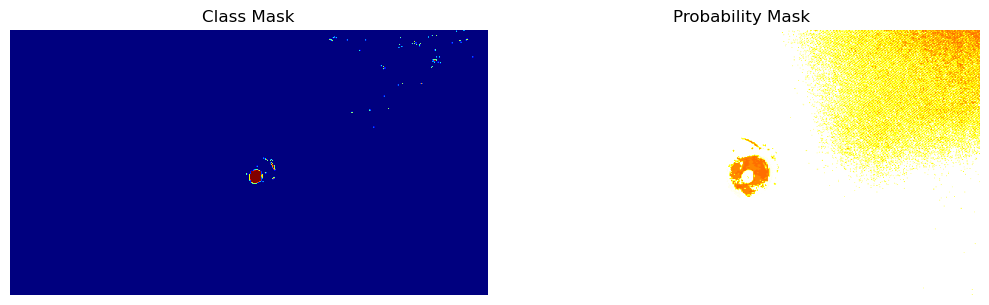

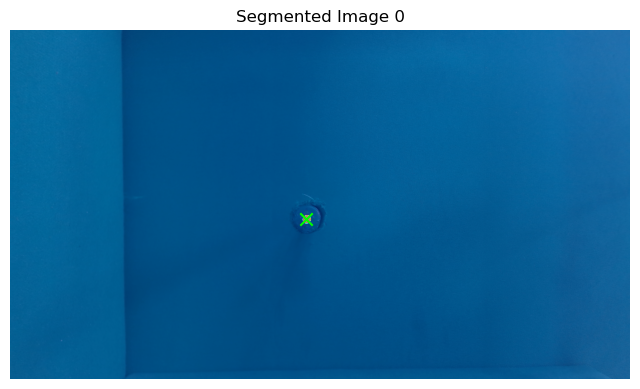

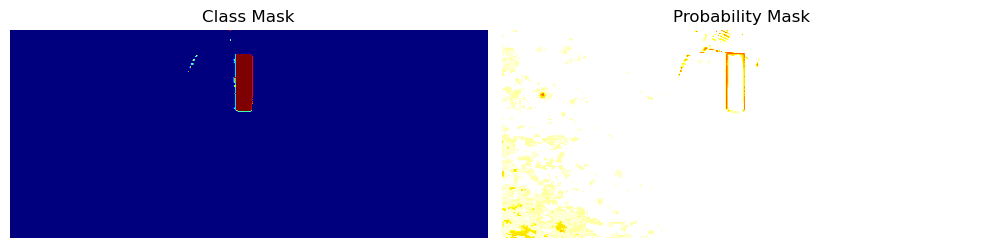

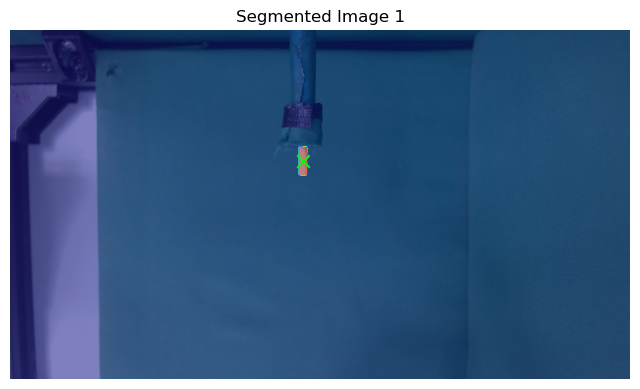

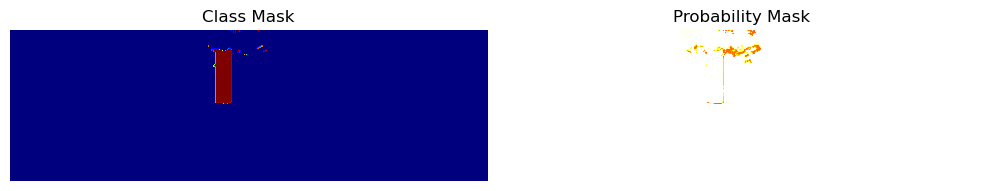

Sorted Skeleton
[[-0.003625  0.003375  0.001875]
 [-0.003625  0.003375  0.001625]
 [-0.003625  0.003125  0.001375]
 [-0.003625  0.003125  0.001125]
 [-0.003625  0.003125  0.000875]
 [-0.003625  0.003125  0.000625]
 [-0.003625  0.003125  0.000375]
 [-0.003625  0.003125  0.000125]
 [-0.003625  0.003125 -0.000125]
 [-0.003625  0.003125 -0.000375]
 [-0.003625  0.003125 -0.000625]]


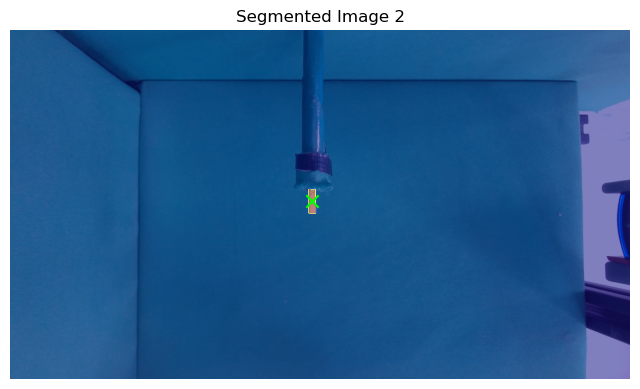

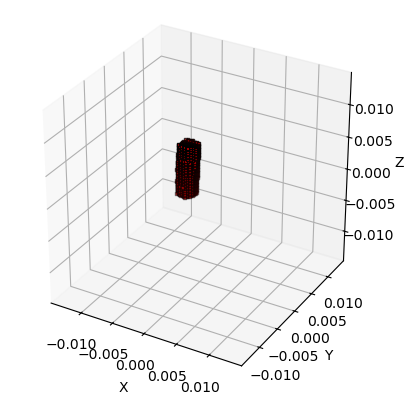

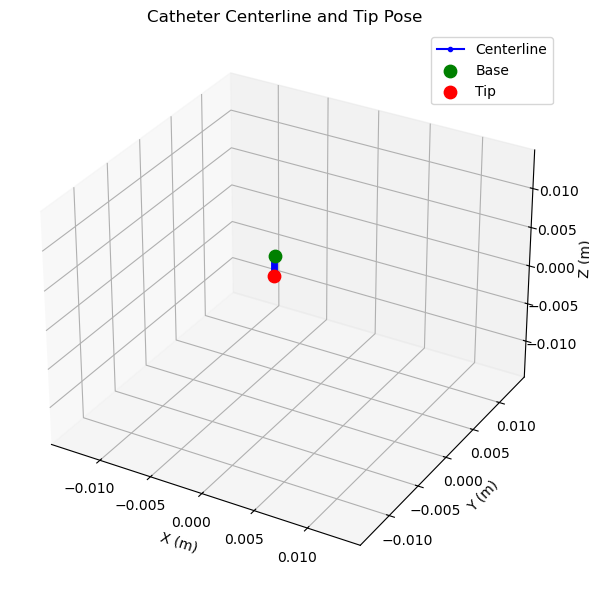

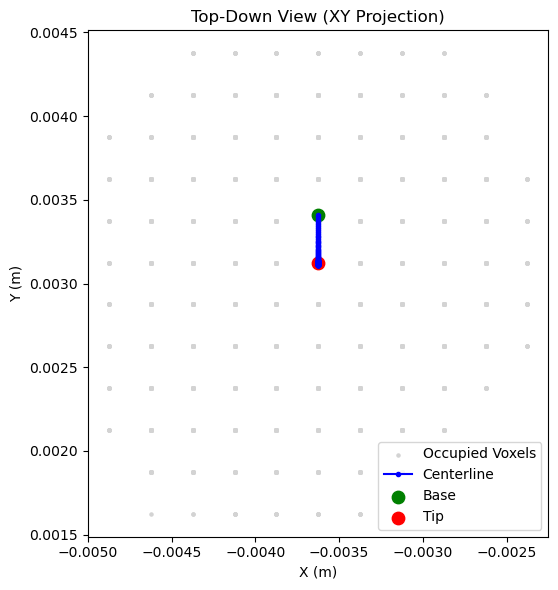

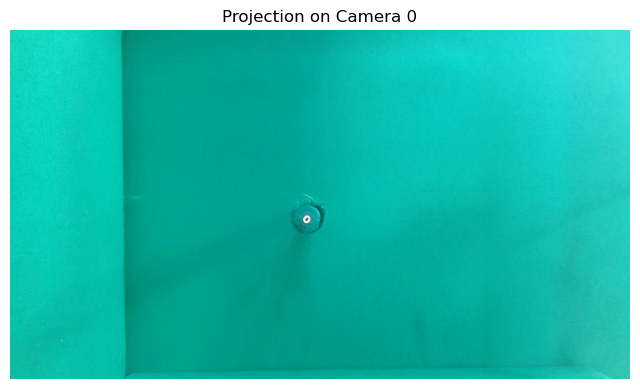

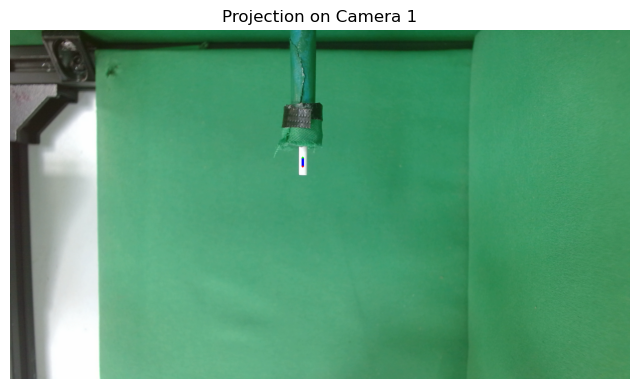

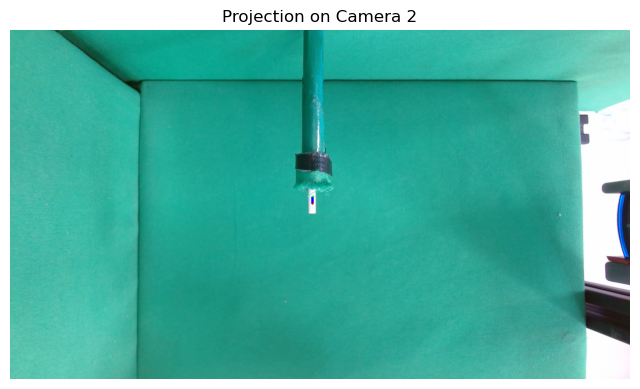

Estimated Tip Position: [array([-0.003625  ,  0.00312014, -0.00062299])]
Estimated Base Position: [array([-0.003625  ,  0.00340997,  0.00186052])]
Estimated Angles (theta, phi): [(6.050832273566883, -1.5707963267948952)]


In [69]:
estimator = CatheterShapeEstimator(force_cpu=True)
tip_pos, base_pos, angles = estimator.estimate_tip_pose(
    images=[test_imgs],
    prompt_type="centroid",
    visualize=True,
    save_path=None,
)
print("Estimated Tip Position:", tip_pos)
print("Estimated Base Position:", base_pos)
print("Estimated Angles (theta, phi):", angles)

## Verify voxel setup

In [ ]:
from camera_calib_data import *

K = [K0, K1, K2]  # Camera intrinsic matrices
d = [d0, d1, d2]  # Distortion coefficients
R = [R_0_w, R_1_w, R_2_w]  # Rotation matrices from world to camera frame
T = [T_0_w, T_1_w, T_2_w]  # Translation vectors from world to camera frame

# Visualize world frame axes on camera frames
for i, img in enumerate(test_imgs):
    img_copy = img.copy()
    # Draw world frame axes
    cv2.drawFrameAxes(
        img_copy, K[i], d[i], R[i], T[i], length=0.03, thickness=2
    )
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.title(f"Camera {i} with World Frame Axes")
    plt.axis("off")
    plt.show()

In [ ]:
from camera_calib_data import *

K = [K0, K1, K2]  # Camera intrinsic matrices
d = [d0, d1, d2]  # Distortion coefficients
R = [R_0_w, R_1_w, R_2_w]  # Rotation matrices from world to camera frame
T = [T_0_w, T_1_w, T_2_w]  # Translation vectors from world to camera frame

num_cams = 3
voxel_size = 0.005
voxel_range = 0.03  # total physical size of voxel space
n_x = int(voxel_range / voxel_size)
n_y = int(voxel_range / voxel_size)
n_z = int(voxel_range / voxel_size)
voxel_map_size = (n_x, n_y, n_z)
# location of physical world frame origin in voxel space
voxel_origin = (
    np.array([(n_x - 1) / 2, (n_y - 1) / 2, (n_z -1) / 2]) * voxel_size
)
# origin = np.array([0, 0, 0])
# Physical world frame coordinates of voxels
voxel_coordinates = (
    np.mgrid[0:n_x, 0:n_y, 0:n_z].reshape(3, -1).T * voxel_size
    - voxel_origin
)
voxel_lookup_table = np.zeros(
    (num_cams, n_x * n_y * n_z, 2), dtype=np.float32
)
for cam_num in range(num_cams):
    rvec, _ = cv2.Rodrigues(
        R[cam_num]
    )  # Rotation vector from rotation matrix
    image_coordinates, _ = cv2.projectPoints(
        voxel_coordinates,
        rvec,
        T[cam_num],
        K[cam_num],
        d[cam_num],
    )
    # print(f"Min image coordinates: {np.min(image_coordinates, axis=0)}")
    # print(f"Max image coordinates: {np.max(image_coordinates, axis=0)}")
    voxel_lookup_table[cam_num, :, :] = image_coordinates.reshape(
        -1, 2
    )

## Adust World Frame

In [70]:
import numpy as np
import pickle

calib_data_path = r"C:\Users\jlim\Documents\GitHub\Catheter-Perception\camera_calibration\08-05-25\camera_calib_data.pkl"
with open(calib_data_path, 'rb') as f:
    camera_calib_data = pickle.load(f)

def adjust_world_frame(p0, p1):
    # Convert points and axes to numpy arrays
    p0 = np.array(p0).flatten()
    p1 = np.array(p1).flatten()
    old_x_axis = np.array([1, 0, 0])
    old_z_axis = np.array([0, 0, 1])
    
    # Step 1: Translate the world frame so that p0 becomes the new origin
    translation = -p0
    
    # Step 2: Compute the new Z-axis as the normalized vector from p0 to p1
    new_z_axis = p0 - p1
    new_z_axis /= np.linalg.norm(new_z_axis)
    
    # Step 3: Project the old X-axis onto the plane perpendicular to the new Z-axis
    # This ensures minimal rotation from the old frame
    projected_x = old_x_axis - np.dot(old_x_axis, new_z_axis) * new_z_axis
    new_x_axis = projected_x / np.linalg.norm(projected_x)
    
    # Step 4: Compute the new Y-axis as the cross product of the new Z and X axes
    new_y_axis = np.cross(new_z_axis, new_x_axis)
    
    # Step 5: Form the rotation matrix from the new axes
    rotation = np.stack((new_x_axis, new_y_axis, new_z_axis)).T
    
    # Step 6: Combine the translation and rotation into a single transformation matrix
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation
    transformation_matrix[:3, 3] = translation
    
    return transformation_matrix


Tr_wnew_w = adjust_world_frame(base_pos, tip_pos)

camera_calib_data_adjusted = camera_calib_data.copy()

# Convert camera calibration matrices to the new world frame
for i in range(3):
    # Adjust rotation and translation for each camera
    R_cam_w = camera_calib_data[f'cam{i}']['extrinsics']['R']
    T_cam_w = camera_calib_data[f'cam{i}']['extrinsics']['T']
    Tr_cam_w = np.eye(4)
    Tr_cam_w[:3, :3] = R_cam_w
    Tr_cam_w[:3, 3] = T_cam_w.flatten()
    # Apply the transformation to the camera pose
    Tr_cam_wnew = Tr_cam_w @ np.linalg.inv(Tr_wnew_w)
    R_cam_wnew = Tr_cam_wnew[:3, :3]
    T_cam_wnew = Tr_cam_wnew[:3, 3]
    print(f"Camera {i} adjusted rotation:\n{R_cam_wnew}")
    print(f"Camera {i} adjusted translation:\n{T_cam_wnew}")
    camera_calib_data_adjusted[f'cam{i}']['extrinsics']['R'] = R_cam_wnew
    camera_calib_data_adjusted[f'cam{i}']['extrinsics']['T'] = T_cam_wnew


Camera 0 adjusted rotation:
[[ 0.02125371  0.98645103 -0.16267341]
 [-0.99973489  0.0224109   0.00528163]
 [ 0.00885572  0.16251803  0.98666583]]
Camera 0 adjusted translation:
[0.0004627  0.00163645 0.15761765]
Camera 1 adjusted rotation:
[[-0.99922506  0.01401888  0.03677982]
 [-0.03830797 -0.13167532 -0.99055243]
 [-0.00904344 -0.99119377  0.13211031]]
Camera 1 adjusted translation:
[-0.004394   -0.01658376  0.13445321]
Camera 2 adjusted rotation:
[[ 0.03399623  0.98311107 -0.17982456]
 [-0.06580889 -0.17733606 -0.98194761]
 [-0.99725295  0.04521657  0.05866869]]
Camera 2 adjusted translation:
[-0.00136616 -0.0036844   0.1554436 ]


## Visualize adjusted world frame